# **Курсовой проект по курсу "Библиотеки Python для Data Science: продолжение"**



---



**Тема:** Используя данные из обучающего датасета (train.csv), построить модель для предсказания факта невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка).
С помощью полученной модели, предсказать факт невыполнения кредитных обязательств из тестового датасета (test.csv).


**Целевая переменная:** Credit Default

**Метрика качества:** F1

**Требования к решению:**
1. https://www.kaggle.com/c/gb-credit-default/

2. F1-score > 0.5 на private Leaderboard.
3. F1-score_1, recall_1, precision_1 > 0.5.
4. Решение прикреплять в ДЗ к Урок 4. Оценка и интерпретация полученной модели. Обсуждение курсового проекта.
5. Указать свой ник на kaggle.


---
---
---

In [116]:
# Размер доступной памяти на выделенной ВРМ
!cat /proc/meminfo | awk '{if($1=="MemAvailable:")print "RAM: "($2/1024/1024)" GB"}'

RAM: 17.0615 GB


In [117]:
# %%sh
# #!/bin/sh
# # Установка необходимых библиотек
# # !pip install --upgrade scikit-learn

# for i in "pip,20.?.?" \
#         "numpy,1.19.?" \
#         "pandas,1.1.5" \
#         "imblearn,0.7.?" \
#         "xgboost,*" \
#         "lightgbm,2.2.?" \
#         "catboost,0.24.?" ; do

#     module=$(echo "$i" | awk -F"," '{print $1}')
#     req_ver=$(echo "$i" | awk -F"," '{print $2}')
#     ver=$(pip show $module 2>&1 | awk -F":" '{
#           if($1=="Version")
#           {
#               ver=$NF
#               gsub(/[ \t\.]+/, "", ver)
#               ver=ver+0
#               if(ver!=0)
#               {
#                   ver=$NF
#                   gsub(/[ \t]+/, "", ver)
#               }
#               print ver
#           }
#           }')
#     if [ "$ver" = "0" ] ; then
#         ver=$(python -c 'import '$module'; print('$module'.__version__)')
#     fi
#     action=$(echo $ver | awk -v rver="$req_ver" \
#         '{
#             if($0!="")
#             {
#                 if(rver!="*")
#                 {
#                     m_count=0
#                     n=split($0,v,".")
#                     m=split(rver,rv,".")
#                     for(i=1;i<=m;i++)
#                     {
#                         if(rv[i]!="?")
#                         {
#                             if(rv[i]==v[i])
#                             {
#                                 m_count++
#                             }
#                             if(rv[i]>v[i])
#                             {
#                                 action="upgrade"
#                             }
#                         }
#                         else
#                         {
#                             m_count=m
#                         }
#                     }
#                     if(m_count<m)
#                     {
#                         action="reinstall"
#                     }
#                 }
#             }
#             else
#             {
#                 action="install"
#             }
#             print action
#         }')

#     if [ -n "$ver" ] ; then
#         if [ "$action" = "upgrade" ] ; then
#             pip install --upgrade $module
#         elif [ "$action" = "reinstall" ] ; then
#             pip install $module==$req_ver
#         else
#             echo $module=$ver, req_ver=$req_ver
#         fi
#     else
#         pip install $module
#     fi

# done

In [118]:
!pip install catboost

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [119]:
!pip install imblearn

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [120]:
# !pip install seaborn==0.11.1

In [121]:
import seaborn as sns

In [122]:
%%sh
for module in pip\
                matplotlib\
                sklearn\
                pandas\
                scipy\
                numpy\
                seaborn\
                imblearn\
                xgboost\
                lightgbm\
                catboost ; do
    
    pip show $module 2>&1 | awk -F":" '{
                                            if($1=="Name"){name=$NF}
                                            if($1=="Version"){ver=$NF}
                                        }
                                        END{print name": "ver}'
done

 pip:  20.3.1
 matplotlib:  3.2.1
 sklearn:  0.0
 pandas:  1.1.5
 scipy:  1.4.1
 numpy:  1.18.5
 seaborn:  0.10.0
 imblearn:  0.0
 xgboost:  1.2.1
 lightgbm:  2.3.1
 catboost:  0.24.3


In [123]:
# Restart session before imports
# import random
# import datetime
import copy
import re
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mannwhitneyu

# Модели и метрики для классификации (предсказания категориальных переменных)
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, Perceptron
from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
    AdaBoostClassifier, VotingClassifier, BaggingClassifier, StackingClassifier
from sklearn import model_selection
from sklearn.model_selection import KFold, GridSearchCV, learning_curve, StratifiedKFold

from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Модели и метрики для регрессии (предсказания вещественных переменных)
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.linear_model import RANSACRegressor, SGDRegressor, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor,\
    BaggingRegressor, RandomForestRegressor, StackingRegressor
from xgboost import XGBRFRegressor, XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import inspect

from IPython.core.display import display, HTML
# display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [124]:
# Let's turn on to display all pandas's rows for searching and analysis.
# Для удобства отключим ограничения вывода строк pandas.
# pd.options.display.max_rows = None
pd.options.display.max_rows = 60

In [125]:
# Дополнительные настройки
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

In [126]:
# Уровень значимости alpha
ALPHA = .05

# Метрика
SCORING = 'f1'

# CURRENT_YEAR = datetime.date.today().year

# Путь к данным
DATA_PATH = '/kaggle/input/gb-credit-default/'
# DATA_PATH = ''

# Путь к выходным данным
OUT_DATA_PATH = '/kaggle/input/save-data/'
# OUT_DATA_PATH = 'out/'

# Путь к моделям
MODELS_PATH = '/kaggle/input/models/'
# MODELS_PATH = 'models/'

# Путь к моделям
OBJECTS_PATH = '/kaggle/input/objects/'
# OBJECTS_PATH = 'obj/'

# Входные данные
TRAIN_FILE = 'train.csv'
TEST_FILE = 'test.csv'
SUBMISSION_FILE = 'sample_submission.csv'

# Шаблон файла с моделью
MODEL_PKL = MODELS_PATH + 'model_ALG.pkl'

# Шаблон выходного файла с предсказаниями
OUT_CSV = 'gb-credit-default_predictions_ALG.csv'

RANDOM_STATE = 42

# Словарь моделей классификации
CLS_MODELS = {
    'LOR': LogisticRegression,
    'PTC': Perceptron,
    'RGC': RidgeClassifier,
    'SGC': SGDClassifier,
    'SVC': SVC,
    'KNC': KNeighborsClassifier,
    'RNC': RadiusNeighborsClassifier,
    'ETC': ExtraTreeClassifier,
    'ABC': AdaBoostClassifier,
    'RFC': RandomForestClassifier,
    'DTC': DecisionTreeClassifier,
    'GBC': GradientBoostingClassifier,
    'XBC': XGBClassifier,
    'XFC': XGBRFClassifier,
    'LBC': LGBMClassifier,
    'CBC': CatBoostClassifier,
    'VOC': VotingClassifier,
    'BAC': BaggingClassifier,
    'STC': StackingClassifier
}

# Словарь моделей регрессии
REG_MODELS = {
    'LIR': LinearRegression,
    'RSC': RANSACRegressor, 
    'SGR': SGDRegressor,
    'LAS': Lasso,
    'SVR': SVR,
    'KNR': KNeighborsRegressor,
    'DTR': DecisionTreeRegressor,
    'ABR': AdaBoostRegressor,
    'ETR': ExtraTreesRegressor,
    'GBR': GradientBoostingRegressor,
    'BAR': BaggingRegressor, 
    'RFR': RandomForestRegressor,
    'XBR': XGBRegressor,
    'XFR': XGBRFRegressor,
    'LBR': LGBMRegressor,
    'CBR': CatBoostRegressor,
    'STR': StackingRegressor
}

# Общий словарь моделей
MODELS = dict(list(CLS_MODELS.items()) + list(REG_MODELS.items()))

# Выходной словарь с результатами (наилучшими моделями, параметрами, метриками)
RESULTS = {}

# Функции

In [127]:
# Восстановление вложенного словаря из строк (В РАЗРАБОТКЕ ДЛЯ ВОЗМОЖНОГО ИСПОЛЬЗОВАНИЯ)
def repare_nested_dict_from_str(dictionary=None):
    if isinstance(dictionary, str):

        # Замена {'...CatBoostClassifier obj...': CatBoostClassifier, nan: np.nan, array: np.array}
        for regex, subst in {r"<(\w+\.)*(\w+) object at 0x\w+>": '\\2',
                            r"\bnan\b": 'np.nan',
                            r"\barray\b": 'np.array'}.items():
            dictionary = re.sub(regex, subst, dictionary, 0, re.MULTILINE)

        # Замена {"'param_grid={'key1': 'value1', ...}": "{'param_grid={'key1': ['value1'], ...}"}
        regex1 = r"(?<=param_grid={)(?P<dict>[^}]+)(?=})"
        # Шаблон, включающий list value ('[value]')
        regex2 = r"(?P<dict>(?P<key>('[^']+')|([\d\.\+-]+))[^:,']*:[^\['\w\.\+-]+(?P<value>(\[?'[^\[']*'\]?)|None|(\[?[\d\.\+-]+\]?)))"
        # Шаблон, исключающий list value ('[value]')
        regex2 = r"(?P<dict>(?P<key>('[^']+')|([\d\.\+-]+))[^:,']*:[^\['\w\.\+-]+(?P<value>('[^\[']*')|None|([\d\.\+-]+)))"
        subst = '\\g<key>: [\\g<value>]'
        ar = re.split(regex1, dictionary)
        for i in range(len(ar)):
            print('-----------------------')
            print(f'ar[{i}]={ar[i]}')
            if i % 2 != 0:
                ar[i] = re.sub(regex2, subst, ar[i], 0, re.MULTILINE)
                print(f'ar[{i}]={ar[i]}')
            print('-----------------------')

        dictionary = ''.join(ar)
        print(type(dictionary))
        print(dictionary)
        print('---------------------------------------------------------------------------------------------')
        print('---------------------------------------------------------------------------------------------')
        dictionary = eval(dictionary) 

    return dictionary

In [128]:
def check_module_version(used_version, needed_version, striction=False):
    '''
    Проверка версии модуля на совместимость
    '''

    assert isinstance(used_version, str), 'used_version не является строкой'
    
    assert isinstance(needed_version, str), 'used_version не является строкой'

    for used_subver, needed_subver in list(zip(used_version.split('.'), needed_version.split('.'))):
        if used_subver.isnumeric() and needed_subver.isnumeric():
            if int(used_subver) < int(needed_subver):
                return False
            elif not striction and int(used_subver) > int(needed_subver):
                return True
        
    return (used_version == needed_version) if striction else True

In [129]:
def get_stacking_estimators(models_dict=None, grid_params=None):
    '''
    Получение параметра estimators для модели StackingClassifier
    input: models_dict = {'ALG': Model(param1=value1, ...), ...},
        grid_params = {'other_param1': other_value1, ...}
    output: [tuple('ALG', Model(param1=value1, ..., other_param1=value1, ...)),...]
    '''
    import copy

    if isinstance(models_dict, dict) and isinstance(grid_params, dict):
        params_dict_ = copy.deepcopy(grid_params)
        for key, value in params_dict_.items():
            if isinstance(value, dict):
                for k, v in value.items():
                    if isinstance(v, (list, tuple, set)):
                        value[k] = v[0]

        stacking_estimators = copy.deepcopy(models_dict)
        for key, value in models_dict.items():
            if hasattr(value, '_init_params'):
                dict_ = value._init_params
            else:
                dict_ = value.__dict__
            params_ = {**dict_, **params_dict_[key]}
            if hasattr(value, '_init_params'):
                stacking_estimators[key]._init_params = params_
            else:
                stacking_estimators[key].__dict__ = params_

        return [(k, i) for k, i in stacking_estimators.items()]

In [130]:
def save_out_predictions(predictions, file_name):
    '''
    Сохранение тестовых данных с ответами в файл
    '''
    submission = pd.read_csv(DATA_PATH + SUBMISSION_FILE)
    submission[TARGET] = predictions
    submission.to_csv(file_name, index=False)

In [131]:
def save_dict(dictionary, file_name):
    '''
    Сохранение словаря в файл (НЕ ИСПОЛЬЗУЕТСЯ)
    '''
    assert isinstance(dictionary, dict), 'dictionary не является словарем'

    import csv
    from os import makedirs, path

    file_name_path = file_name[:file_name.rfind('/') + 1]
    if len(file_name_path) and not path.exists(file_name_path):
        makedirs(file_name_path)

    with open(file_name, 'w') as file:
        writer = csv.DictWriter(file, dictionary.keys())
        writer.writeheader()
        writer.writerow(dictionary)

In [132]:
def load_dict(file_name):
    '''
    Загрузка словаря(ей) из файла (НЕ ИСПОЛЬЗУЕТСЯ)
    '''
    import os.path
    import csv

    assert os.path.exists(file_name), f'Не найден файл словаря "{file_name}""'

    list_of_dicts = []
    with open(file_name, 'r') as file:
        for row in csv.DictReader(file):
            list_of_dicts.append(dict(row))
    return list_of_dicts

In [133]:
def save_data(data, file_name, multiindex=False):
    '''
    Сохранение данных в файл
    '''
    
    assert isinstance(data, (list, tuple, set, pd.DataFrame, pd.Series, np.ndarray)), \
        'data не является датафреймом pandas или их списком/tuple/set'

    assert isinstance(file_name, (list, tuple, set, str)), \
        'file_name не является строкой или их списком/tuple/set'

    from os import makedirs, path

    file_name_path = file_name[:file_name.rfind('/') + 1]
    if len(file_name_path) and not path.exists(file_name_path):
        makedirs(file_name_path)

    if isinstance(data, (pd.DataFrame, pd.Series, np.ndarray)):
        data = [data]

    if isinstance(file_name, str):
        f_name = file_name
        file_names = None
    else:
        file_names = file_name

    if isinstance(data, (list, tuple, set)):

        for i, dataset in enumerate(data):

            assert isinstance(dataset, (pd.DataFrame, pd.Series, np.ndarray)), \
                'data не является датафреймом pandas или их списком/tuple/set'

            if file_names is not None and len(file_names) > i:
                file_name = file_names[i]
            else:
                file_name = f_name[:f_name.rfind('.')] + f'{i:03d}' + f_name[f_name.rfind('.'):]

            file_ext = file_name[file_name.rfind('.') + 1:].lower()
            if file_ext == 'zip' or file_ext == 'bz2' or file_ext == 'gzip' or file_ext == 'xz':
                compression = file_ext
            else:
                compression = None

            dataset.to_csv(file_name, compression=compression, index=multiindex)

In [134]:
def load_data(*args, multiindex=False):
    '''
    Загрузка данных из файла
    '''
    import os.path

    dfs_out = []
    if args is not None:
        for file_name in args:

            assert os.path.exists(file_name), f'Не найден файл данных "{file_name}"'

            file_ext = file_name[file_name.rfind('.') + 1:].lower()
            if file_ext == 'zip' or file_ext == 'bz2' or file_ext == 'gzip' or file_ext == 'xz':
                compression = file_ext
            else:
                compression = None

            df = pd.read_csv(file_name, compression=compression, index_col=multiindex)

            if not multiindex and isinstance(df, pd.DataFrame) and df.shape[1] == 1:
                df = pd.Series(df.iloc[:, -1])

            dfs_out.append(df)
    return dfs_out

In [135]:
# # Проверка сохранения и восстановления датасетов
# result = results.copy()
# result[0] = result[0].round(2)
# result[1] = result[1].round(2)
# result[4] = result[4].round(2)
# data = result.copy()

# for ext in ['csv', 'zip', 'gz', 'xz']:
#     # Сохранение данных до обучения и предсказания в файлы
#     save_data(result, OUT_DATA_PATH + 'data_before_predict_0_.' + ext)

#     # Загрузка данных до обучения и предсказания из файлов
#     data = load_data(*(OUT_DATA_PATH + 'data_before_predict_0_000.' + ext,
#                        OUT_DATA_PATH + 'data_before_predict_0_001.' + ext,
#                        OUT_DATA_PATH + 'data_before_predict_0_002.' + ext,
#                        OUT_DATA_PATH + 'data_before_predict_0_003.' + ext,
#                        OUT_DATA_PATH + 'data_before_predict_0_004.' + ext))
    
#     for i in range(len(data)):
#         print(ext, i, data[i].equals(result[i]))


In [136]:
def save_obj(obj, file_name, bin_format=True):
    '''
    Сохранение объекта/модели в файл
    '''
    from os import makedirs, path
    file_name_path = file_name[:file_name.rfind('/') + 1]
    if len(file_name_path) and not path.exists(file_name_path):
        makedirs(file_name_path)

    if bin_format:
        bin, protocol = 'b', pickle.HIGHEST_PROTOCOL
    else:
        bin, protocol = '', pickle.DEFAULT_PROTOCOL
    with open(file_name, 'w' + bin) as file:
        pickle.dump(obj, file, protocol)    

In [137]:
def load_obj(file_name, bin_format=True):
    '''
    Загрузка объекта/модели из файла
    '''
    import os.path

    assert os.path.exists(file_name), f'Не найден файл модели "{file_name}""'

    bin = 'b' if bin_format else ''
    with open(file_name, 'r' + bin) as file:
        return pickle.load(file)

In [138]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    return 'TRAIN\n\n' + classification_report(y_train_true, y_train_pred) + \
        '\nTEST\n\n' + classification_report(y_test_true, y_test_pred) + \
        '\nCONFUSION MATRIX\n\n' + str(pd.crosstab(y_test_true, y_test_pred))

In [139]:
def get_metrics(y_train, y_train_pred, y_test, y_test_pred, scoring='f1'):
    '''
    Получение словаря с заданной метрикой (В РАЗРАБОТКЕ)
    '''
    metrics = {}
    if scoring == 'r2' or scoring == 'r2_score':
        metrics['train'] = r2_score(y_train, y_train_pred)
        metrics['test'] = r2_score(y_test, y_test_pred)
    elif scoring == 'f1' or scoring == 'f1_score':
        metrics['train'] = f1_score(y_train, y_train_pred)
        metrics['test'] = f1_score(y_test, y_test_pred)
    elif scoring == 'precision':
        metrics['train'] = precision_score(y_train, y_train_pred)
        metrics['test'] = precision_score(y_test, y_test_pred)
    elif scoring == 'recall':
        metrics['train'] = recall_score(y_train, y_train_pred)
        metrics['test'] = recall_score(y_test, y_test_pred)
    elif scoring == 'class_report':
        metrics['report'] = get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
    return metrics

In [140]:
def get_f1_scores_df(results: dict):
    '''
    Вывод всех протестированных алгоритмов и метрикой f1-score
    '''
    return pd.DataFrame(
        [(x['algorithm'],
        x['train']['1.0']['f1-score'],
        x['train']['macro avg']['f1-score'],
        x['test']['1.0']['f1-score'],
        x['test']['macro avg']['f1-score']) for x in results.values()],
        columns=['algorithm', 'train f1', 'train macro avg f1', 'test f1', 'test macro avg f1']
        ).sort_values('test macro avg f1', ascending=False)

In [141]:
def get_dict_for_renaming_cols(columns=None):
    '''
    Переименование столбцов для XGBoost, содержащих знаки "[, ] or <"
    '''
    if columns is not None:
            
        assert isinstance(columns, (list, pd.core.indexes.base.Index)), \
            'Входной параметр "columns" не является списком или Index pandas'

        columns_out = {}
        for col in columns:
            if re.search(r'(\s|\b)(><)|(<>)|(!=)(\s|\b)', col, 0):
                columns_out[col] = re.sub(r'(\s|\b)(><)|(<>)|(!=)(\s|\b)', '_ne_', col, 0)
            elif re.search(r'(\s|\b)(<=|=<)(\b|\s)', col, 0):
                columns_out[col] = re.sub(r'(\s|\b)(<=|=<)(\b|\s)', '_le_', col, 0)
            elif re.search(r'(\s|\b)(>=|=>)(\b|\s)', col, 0):
                columns_out[col] = re.sub(r'(\s|\b)(>=|=>)(\b|\s)', '_ge_', col, 0)
            elif re.search(r'(\s|\b)>(\b|\s)', col, 0):
                columns_out[col] = re.sub(r'(\s|\b)>(\b|\s)', '_gt_', col, 0)
            elif re.search(r'(\s|\b)<(\b|\s)', col, 0):
                columns_out[col] = re.sub(r'(\s|\b)<(\b|\s)', '_lt_', col, 0)
            elif re.search(r'(\s|\b)={1,2}(\b|\s)', col, 0):
                columns_out[col] = re.sub(r'(\s|\b)={1,2}(\b|\s)', '_eq_', col, 0)
            elif re.search(r'(^|\s|\b)\+(\s|\b|$)', col, 0):
                columns_out[col] = re.sub(r'(^|\s|\b)\+(\s|\b|$)', '_plus_', col, 0)
            elif re.search(r'[А-Яа-яЁё]', col, 0):
                col_ = columns_out[col]
                letters = {'а':'a','б':'b','в':'v','г':'g','д':'d','е':'e','ё':'e',
                    'ж':'zh','з':'z','и':'i','й':'y','к':'k','л':'l','м':'m','н':'n',
                    'о':'o','п':'p','р':'r','с':'s','т':'t','у':'u','ф':'f','х':'kh',
                    'ц':'c','ч':'ch','ш':'sh','щ':'sch','ь':'','ы':'y','ъ':'','э':'e',
                    'ю':'u','я':'ya', 'А':'A','Б':'B','В':'V','Г':'G','Д':'D','Е':'E','Ё':'E',
                    'Ж':'ZH','З':'Z','И':'I','Й':'Y','К':'K','Л':'L','М':'M','Н':'N',
                    'О':'O','П':'P','Р':'R','С':'S','Т':'T','У':'U','Ф':'F','Х':'KH',
                    'Ц':'C','Ч':'CH','Ш':'SH','Щ':'SCH','Ь':'','Ы':'Y','Ъ':'','Э':'E',
                    'Ю':'U','Я':'YA'}
                for key in letters:
                    col_ = col_.replace(key, letters[key])
                columns_out[col] = col_
            elif re.search(r'[^ A-Za-z0-9_]', col, 0):
                columns_out[col] = re.sub(r'[^ A-Za-z0-9А-Яа-я_]', '_', col, 0)
    return columns_out

In [142]:
def preprocess_outlier(df, feature, threshold=None, lower_threshold=None, is_quantile=False):
    '''
    Отсечка выбросов (заполнение всех данных признака выше(ниже) порога(ов) NaN)
    '''

    assert isinstance(df, pd.DataFrame), 'Параметр не является датафреймом pandas'

    assert feature in df.columns, f'Не найден заданный признак "{feature}" во входном датафрейме pandas'

    assert isinstance(threshold, (int, float, type(None))), 'Нечисловое значение "threshold"'

    assert isinstance(lower_threshold, (int, float, type(None))), 'Нечисловое значение "lower_threshold"'

    if threshold is not None:
        if is_quantile and 0 < threshold < 1:
            threshold = df[feature].quantile(threshold)

    if lower_threshold is not None:
        if is_quantile and 0 < lower_threshold < 1:
            lower_threshold = df[feature].quantile(lower_threshold)

    if threshold is not None and lower_threshold is not None:
        if lower_threshold > threshold:
            lower_threshold, threshold = threshold, lower_threshold
        df.loc[(df[feature] > threshold) | (df[feature] < lower_threshold), feature] = np.nan
    elif threshold is not None and lower_threshold is None:
        df.loc[df[feature] > threshold, feature] = np.nan
    elif lower_threshold is not None and threshold is None:
        df.loc[df[feature] < lower_threshold, feature] = np.nan

    return df

In [143]:
def show_learning_curve_plot(estimator, estimator_name, X, y, cv=5, n_jobs=-1,
                             scoring='f1', train_sizes=np.linspace(.1, 1.0, 5)):
    '''
    Подбор оптимального размера выборки, кривая обучения
    '''
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring=scoring,
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    best_size = train_sizes[test_scores_mean.argmax()]
    best_test_score = test_scores_mean.max()

    plt.figure(figsize=(16, 8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='g')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='r')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='g', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='r', label='Cross-validation score')
    
    plt.axvline(best_size, ls='--', color='m',
                label=f'train size={best_size} ({round(100 * best_size / X.shape[0], 2)} %)')
    plt.axhline(best_test_score, ls='--', color='c',
                label=f'max test {scoring}={round(best_test_score, 4)}')

    plt.title(f'Learning curves ({estimator_name})')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    return best_size, best_test_score

In [144]:
def show_seaborn_pointplot(df_train, df_test, num_feature=None, cat_features=None):
    if num_feature is not None and cat_features is not None:
        for col in cat_features:
            plt.figure(figsize=(10, 5))
            sns.pointplot(x=col, y=num_feature, data=df_train, capsize=.1, label='train', color='g')
            sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='r')
            plt.title(col) 
            plt.show()

In [145]:
def show_features_importance_bars(results_dict, x_y_keys_list, features, **kwargs):
    '''
    Построение баров признаков значимости для моделей
    '''

    assert isinstance(x_y_keys_list, list) and len(x_y_keys_list) == 2, \
        'x_y_keys_list не является списком из 2-х ключей'

    x_y_keys_dict = dict({})
    for key, value_dict in results_dict.items():
        if isinstance(value_dict, dict):
            value_0 = get_nested_dict_value(value_dict, x_y_keys_list[0], striction=False)
            value_1 = get_nested_dict_value(value_dict, x_y_keys_list[1], striction=False)
            if isinstance(value_0, str) and value_1 is not None:
                x_y_keys_dict[value_0 + '_' + str(key)] = list(value_1)

    if len(x_y_keys_dict) > 0:
        df = pd.DataFrame(data=x_y_keys_dict, index=list(features))

        for model in df.columns:
            df_ = pd.DataFrame(df[model]).sort_values(model, ascending=False)
            fig, ax = plt.subplots(figsize=(10, 15))
            sns.barplot(ax=ax, x=df_[model], y=df_.index, **kwargs)
            plt.title(f'Correlation with target variable for model {model}')
            plt.show()

        return df

In [146]:
def show_metrics_bars(results_dict, x_yy_keys_list, scoring='f1', **kwargs):
    '''
    Построение баров метрик
    '''
    x_yy_keys_dict = dict({})
    for key in x_yy_keys_list:
        x_yy_keys_dict['/'.join(key)] = [get_nested_dict_value(v, key) for v in results_dict.values()]
    
    df_metrics = pd.DataFrame(x_yy_keys_dict)
    columns = df_metrics.columns
    df_metrics_min_min = np.min(df_metrics[columns[1:]]).min()
    df_metrics_row_max = np.max(df_metrics[columns[1:]], axis=1).idxmax()
    df_metrics_col_max = np.max(df_metrics[columns[1:]], axis=0).idxmax()
    df_metrics_col_min = np.max(df_metrics[columns[1:]], axis=0).idxmin()
    df_metrics_max_min = df_metrics.iloc[df_metrics_row_max][columns[1:]].min()
    df_metrics_max_max = df_metrics[df_metrics_col_max].max()
    df_metrics_row_max = df_metrics.iloc[df_metrics_row_max][columns[0]]
    
    plt.figure(figsize=(16, 8))
    x = df_metrics.index
    width = .7 / (df_metrics.shape[1] - 1)
    i = - ((df_metrics.shape[1] - 1) // 2)
    for col in columns[1:]:
        plt.bar(x - i*width, list(df_metrics[col]), width, label=col, **kwargs)
        i += 1
    plt.xticks(df_metrics.index, df_metrics[columns[0]])
    plt.ylim((df_metrics_min_min - .1 * df_metrics_min_min, df_metrics_max_max + .1 * df_metrics_max_max))

    plt.axhline(df_metrics_max_max, ls='--', color='c',
                label=f'{df_metrics_row_max} max {df_metrics_col_max}={round(df_metrics_max_max, 4)}')

    plt.axhline(df_metrics_max_min, ls=':', color='m',
                label=f'{df_metrics_row_max} min {df_metrics_col_min}={round(df_metrics_max_min, 4)}')

    plt.title(f'Training metrics {scoring}')
    plt.xlabel('Algorithms')
    plt.ylabel(f'Score {scoring}')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    return df_metrics

In [147]:
def get_nested_dict_value(dictionary=None, nested_keys_list=None, striction=True):
    '''
    Получение значений из вложенного словаря по ключу вида 'key0/subkey1/subsubkey2/...'
    '''

    assert isinstance(dictionary, dict), 'dictionary не является словарем'

    assert isinstance(nested_keys_list, list) and len(nested_keys_list), \
        'nested_keys_list не является непустым списком'

    value = None
    found = False
    d = dictionary
    for key in nested_keys_list:
        if isinstance(d, dict) and key in d.keys():
            value = d[key]
            d = d[key]
            found = True
        else:
            if striction:
                found = False
                break
                
    if striction:
        
        assert found, f'Ключ "{key}" в словаре dictionary не найден'
    
    return value

In [148]:
def imputer_by_model(data, target, model=None, test_size=0.3, shuffle=True, random_state=None,
                     algorithm='RFR', scoring='r2', model_file_name=None, no_fit=False, silent=False):
    '''
    Заполнение NaN с помощью модели
    '''
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target].isna()]
    predict_data = data[data[target].isna()]

    X = train.drop(columns=target)
    y = train[target]

    adjusting = {}

    # print('1')
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                                        test_size=test_size,
                                                        shuffle=shuffle,
                                                        random_state=random_state)
    # print('2')
    
    if model is None:
        model = RandomForestRegressor(n_estimators=100,
                                      max_depth=5,
                                      random_state=random_state,
                                      verbose=0)
    
    # print('3')
    # print(type(model))
    # print(tuple(MODELS.values()))
    # print(isinstance(model, tuple(MODELS.values())))

    # Запись настроек и метрик
    adjusting['algorithm'] = algorithm
    adjusting['model'] = model

    # assert isinstance(model, tuple(MODELS.values())), 'Не задана модель для предсказания пропусков'

    if not no_fit:
        if not silent:
            print(f"Fitting target '{target}' on model '{MODELS[algorithm].__name__}'...")
        # print('4')
        model.fit(X_train, y_train)
        
    # print('5')
    pred_train = model.predict(X_train)

    # print('6')
    pred_test = model.predict(X_test)

    metrics = get_metrics(y_train, pred_train, y_test, pred_test, scoring=scoring)
    
    # print('7')
    if not silent:
        print(f"target: '{target}', model: {MODELS[algorithm].__name__}")
        print(f"{scoring} train: {metrics['train']}")
        print(f"{scoring} test:  {metrics['test']}")

    # print('8')
    # Сохранение метрик
    adjusting[f'train_{scoring}_score'] = metrics['train']
    adjusting[f'test_{scoring}_score'] = metrics['test']
    # metrics['precision_score'] = precision_score(y_valid, y_valid_pred)
    # metrics['recall_score'] = recall_score(y_valid, y_valid_pred)

    # # Получение отчетов и датафреймов с результатами
    # metrics['report'] = get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

    # Запись наилучших параметров
    if hasattr(model, 'best_params_'):
        adjusting['best_params'] = model.best_params_
        print(f'best params: {model.best_params_}')

    # Запись наилучшей модели-оценщика
    if hasattr(model, 'best_estimator_'):
        adjusting['best_estimator'] = model.best_estimator_

        # print("hasattr(model.best_estimator_, 'feature_importances_')=",hasattr(model.best_estimator_, 'feature_importances_'))

        # Запись важности признаков
        if hasattr(model.best_estimator_, 'feature_importances_'):
            adjusting['feature_importances'] = model.best_estimator_.feature_importances_

        model = model.best_estimator_

    if not silent:
        best_size, best_test_score = show_learning_curve_plot(
            model,
            str(MODELS[algorithm].__name__),
            X_train,
            y_train,
            scoring=scoring)
                    
        # Запись наилучших разбиения выборки и метрики
        adjusting['best_size'] = best_size
        adjusting['best_test_score'] = best_test_score

        print(best_size, best_test_score)

    # Сохранение модели в файл
    if model_file_name is not None and isinstance(model_file_name, str):
        save_obj(model, model_file_name)

        # Запись имени файла модели
        adjusting['model_file_name'] = model_file_name

        print(f'"{model_file_name}"')

    pred = model.predict(predict_data.drop(columns=target))

    data.loc[data[target].isna(), target] = list(pred)

    return model, data, adjusting

In [149]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))
    '''
    Выбор порога вероятности для определения класса
    '''

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [150]:
def balance_df_by_multiclass_target(df,
                                    target,
                                    method='smote',
                                    balancing_threshold=0.7,
                                    random_state=None,
                                    k_neighbors=5,
                                    shuffle=True,
                                    silent=True):
    '''
    Балансировка применяется только для обучающей выборки задачи классификации
    Цикл используется для мультиклассовой классификации
    '''

    assert method in ['over', 'under', 'tomek', 'smote', 'smotetomek', 'adasyn'], \
        'Неверный метод сэмплирования'

    assert isinstance(random_state, (type(None), int)), 'Нечисловое значение random_state'

    assert isinstance(k_neighbors, int), 'Нечисловое значение k_neighbors'

    assert isinstance(silent, bool), 'Небулевое значение silent'

    assert df[target].value_counts().size < 10, \
        f'Скорее всего целевая переменная "{target}" не предназначена для задачи классификации'

    if method not in ['over', 'under']:

        assert df.select_dtypes(include='object').columns.size == 0, \
            'Требуется предварительно преобразовать категориальные признаки в вещественные'

        assert df.isna().sum().sum() == 0, \
            'Требуется предварительно избавиться от пропусков данных'

    iteration = 0
    disbalance_coeff_prev = 0
    X_res, y_res = None, None

    while True:

        target_counts = df[target].value_counts()
        major_class_name = target_counts.idxmax()
        minor_class_name = target_counts.idxmin()
        major_class_counts = target_counts[major_class_name]
        minor_class_counts = target_counts[minor_class_name]
        disbalance_coeff = minor_class_counts / major_class_counts

        if not silent:
            iteration += 1
            print(f'\niteration: {iteration} -----------------------')
            print(f'target_counts:\n{target_counts}')
            print(f'target_counts.size={target_counts.size}')
            print(f'major_class_name={major_class_name}')
            print(f'minor_class_name={minor_class_name}')
            print(f'major_class_counts={major_class_counts}')
            print(f'minor_class_counts={minor_class_counts}')
            print(f'disbalance_coeff={disbalance_coeff}')

        assert disbalance_coeff_prev < disbalance_coeff, \
            f'Не удалось достичь заданного уровня баланса объектов для метода сэмплирования "{method}"'

        if disbalance_coeff > balancing_threshold:
            break
        else:
            disbalance_coeff_prev = disbalance_coeff

        if method == 'over':
            sample = df[df[target] == minor_class_name].sample(
                major_class_counts - minor_class_counts,
                replace=(major_class_counts - minor_class_counts > minor_class_counts),
                random_state=random_state
                )
            df = df.append(sample, ignore_index=True)
            
        elif method == 'under':

            assert minor_class_counts > 100, \
                'Слишком мало объектов миноритарного класса для метода сэмплирования "under"'

            r = np.random.RandomState(random_state)
            df_ = df.copy()
            df = df_[df_[target] == minor_class_name]
            df_major = df_[df_[target] == major_class_name]
            df = df.append(df_major.iloc[
                r.randint(0, df_major.shape[0], target_counts[minor_class_name])
            ], ignore_index=True)

        elif method == 'tomek':
            from imblearn.under_sampling import TomekLinks
            tl = TomekLinks(n_jobs=-1)
            X_res, y_res = tl.fit_sample(df.drop(columns=target), df[target])

        elif method == 'adasyn':
            from imblearn.over_sampling import ADASYN
            ada = ADASYN(n_jobs=-1,
                         random_state=random_state,
                         n_neighbors=k_neighbors)

            assert minor_class_counts > ada.n_neighbors + 1, \
                'Слишком мало объектов миноритарного класса для метода сэмплирования "ADASYN"'

            X_res, y_res = ada.fit_sample(df.drop(columns=target), df[target])

        elif method == 'smote':
            from imblearn.over_sampling import SMOTE
            sm = SMOTE(n_jobs=-1,
                       random_state=random_state,
                       k_neighbors=k_neighbors)

            assert minor_class_counts > sm.k_neighbors + 1, \
                'Слишком мало объектов миноритарного класса для метода сэмплирования "SMOTE"'

            X_res, y_res = sm.fit_sample(df.drop(columns=target), df[target])

        elif method == 'smotetomek':
            from imblearn.combine import SMOTETomek 
            smt = SMOTETomek(random_state=random_state)

            assert minor_class_counts > 6, \
                'Слишком мало объектов миноритарного класса для метода сэмплирования "SMOTETomek"'

            X_res, y_res = smt.fit_sample(df.drop(columns=target), df[target])

        if method not in ['over', 'under']:

            assert X_res is not None and y_res is not None, \
                f'Ошибка выполнения метода сэмплирования "{method}"'

            from imblearn import __version__
            if __version__ == '0.4.3':
                # for imblearn.__version__ = 0.4.3
                df = pd.DataFrame(
                    np.insert(X_res, df.columns.get_loc(target), y_res, axis=1),
                    columns=df.columns)
            else:
                # for imblearn.__version__ = 0.7.0
                df = pd.concat([X_res, y_res], axis=1)

    if shuffle:
        return df.sample(frac=1, random_state=random_state).reset_index()
    else:
        return df

In [151]:
def copy_dfs(dfs_in=None):
    '''
    Batch function
    Бекап датасетов
    input:  dfs_in  = [df_train, df_test]
    output: dfs_out = [df_train_copy, df_test_copy]
    '''

    assert isinstance(dfs_in, (list, type(None))), 'dfs_in не является списком'

    dfs_out = []
    if dfs_in is not None:
        for df in dfs_in:

            assert isinstance(df, pd.DataFrame), 'Элемент списка dfs_in не является датафреймом pandas'

            dfs_out.append(df.copy())

    return dfs_out

In [152]:
def fillna_by_fitted_models(dfs_in=None, **kwargs):
    '''
    Batch function
    Заполнение NaN с помощью заранее обученных моделей
    Для линейных моделей предварительное масштабирование данных (scaler=sklearn_scaler)
    (масштабирование выполняется для каждого признака и не влияет на выходные данные)
    input:  dfs_in  = [df_train, df_test]
    output: dfs_out = [df_train_fillna_by_fitted_models, df_test_fillna_by_fitted_models]
    '''

    assert isinstance(dfs_in, (list, type(None))), 'dfs_in не является списком'

    scaler = None
    fitted_models = None
    shuffle=True
    no_fit=False
    silent = False
    scoring = 'r2'
    model_file_name = None
    if kwargs is not None:
        for key, item in kwargs.items():
            if key == 'scaler':
                scaler = item
            elif key == 'fitted_models':
                fitted_models = item
            elif key == 'shuffle':
                shuffle = item
            elif key == 'no_fit':
                no_fit = item
            elif key == 'silent':
                silent = item
            elif key == 'scoring':
                scoring = item
            elif key == 'model_file_name':
                model_file_name = item

    assert isinstance(fitted_models, dict), \
        'Параметр fitted_models не задан или не является словарем с обученными моделями'

    dfs_out = []
    if dfs_in is not None:
        for df in dfs_in:

            assert isinstance(df, pd.DataFrame), 'Элемент списка dfs_in не является датафреймом pandas'

            for feature, fitted_model_file_name in fitted_models.items():

                nan_features = df.columns[df.isna().sum() > 0].tolist()
                # print('1.\nnan_features:\n', nan_features)

                if feature in nan_features:

                    # Список признаков, участвующих в предсказании признака feature
                    not_nan_features = list(set(df.columns) - set(nan_features)) + [feature]
                    # print('2.\nnot_nan_features:\n', not_nan_features)

                    df_copy = df[not_nan_features].copy()
                    # print('3.\ndf_copy:\n', df_copy)

                    # Масштабирование датасета, кроме признака feature
                    if scaler is not None:
                        # print('3.1')
                        df_copy = scale_X_train_valid_test(dfs_in=[df_copy],
                                                           scaler=scaler,
                                                           untouched_features=[feature])[0]
                        # print('3.2')
                        # for f in df_copy.columns:
                        #     print(f'{f}: min: {df_copy[f].min()} max: {df_copy[f].max()}')

                    # print('4.\nfitted_model:\n')
                    fitted_model = load_obj(fitted_model_file_name)
                    # print('5.\nfitted_model:\n')
                    # print('4.\nfitted_model:\n', fitted_model)

                    algorithm = None
                    for alg, mdl in MODELS.items():
                        # print(alg)
                        # print(mdl.__name__)
                        # print(fitted_model.__class__.__name__)
                        # print(mdl.__name__ == fitted_model.__class__.__name__)
                        if mdl.__name__ == fitted_model.__class__.__name__:
                            algorithm = alg
                            break

                    # Предсказание признака feature обученной моделью
                    predictor, df_copy, results = imputer_by_model(df_copy,
                                                                   feature,
                                                                   model=fitted_model,
                                                                   test_size=0.3,
                                                                   shuffle=shuffle,
                                                                   random_state=RANDOM_STATE,
                                                                   algorithm=algorithm,
                                                                   scoring=scoring,
                                                                   model_file_name=model_file_name,
                                                                   no_fit=no_fit,
                                                                   silent=silent)
                    
                    # print('5.\ndf_copy:\n', df_copy)
                    df[feature] = df_copy[feature]
                    # print('6.\ndf:\n', df)
                    # for f in df_copy.columns:
                    #     print(f'{f}: min: {df_copy[f].min()} max: {df_copy[f].max()}')
                    # df.info()

            if isinstance(df, pd.DataFrame):
                dfs_out.append(df)

    return dfs_out

In [153]:
def fillna_dfs(dfs_in=None, **kwargs):
    '''
    Batch function
    Заполнение NaN via fillna
    input:  dfs_in  = [df_train, df_test]
    output: dfs_out = [df_train_fillna_by_method, df_test_fillna_by_method]
    '''

    assert isinstance(dfs_in, (list, type(None))), 'dfs_in не является списком'

    method = 0
    if kwargs is not None:
        for key, item in kwargs.items():
            if key == 'method':
                method = item

    dfs_out = []
    if dfs_in is not None:
        for df in dfs_in:

            assert isinstance(df, pd.DataFrame), 'Элемент списка dfs_in не является датафреймом pandas'

            if isinstance(method, (int, float)):
                dfs_out.append(df.fillna(method))
            else:
                dfs_out.append(df.fillna(method=method))

    return dfs_out

In [154]:
def fillna_medians_dfs(dfs_in=None, **kwargs):
    '''
    Batch function
    Заполнение NaN via median()/value_counts().idxmax()
    input:  dfs_in  = [df_train, df_test]
    output: dfs_out = [df_train_fillna_with_median_or_value_counts-idxmax, df_test_fillna_with_median_or_value_counts-idxmax]
    '''

    assert isinstance(dfs_in, (list, type(None))), 'dfs_in не является списком'

    num_features = None
    cat_features = None
    if kwargs is not None:
        for key, item in kwargs.items():
            if key == 'num_features':
                num_features = item
            elif key == 'cat_features':
                cat_features = item

    assert isinstance(num_features, (list, type(None))), 'num_features не является списком'

    assert isinstance(cat_features, (list, type(None))), 'cat_features не является списком'

    dfs_out = []
    if dfs_in is not None:
        for df in dfs_in:

            assert isinstance(df, pd.DataFrame), 'Элемент списка dfs_in не является датафреймом pandas'

            df_ = df.copy()

            if num_features is not None:
                for feature in num_features:
                    df_[feature] = df[feature].fillna(df[feature].median())
                
            if cat_features is not None:
                for feature in cat_features:
                    df_[feature] = df[feature].fillna(df[feature].value_counts().idxmax())

            dfs_out.append(df_)

    return dfs_out

In [155]:
def fill_dfs_outliers_to_na(dfs_in=None, **kwargs):
    '''
    Batch function
    Заполнение выбросов NaN
    input:  dfs_in  = [df_train, df_test]
    output: dfs_out = [df_train_fillna_outliers, df_test_fillna_outliers]
    '''

    assert isinstance(dfs_in, (list, type(None))), 'dfs_in не является списком'

    thresholds = None
    is_quantile = False
    if kwargs is not None:
        for key, item in kwargs.items():
            if key == 'thresholds':
                thresholds = item
            elif key == 'is_quantile':
                is_quantile = item

    assert isinstance(thresholds, (dict, type(None))), 'thresholds не является словарем с пороговыми значениями'

    dfs_out = []
    if dfs_in is not None:
        for df in dfs_in:

            assert isinstance(df, pd.DataFrame), 'Элемент списка dfs_in не является датафреймом pandas'

            df_ = df.copy()

            for feature, threshold_range in thresholds.items():
                if feature in df_.columns:
                    
                    lower_threshold, threshold = None, None
                    if isinstance(threshold_range, (list, tuple)) and len(threshold_range) > 1:
                        lower_threshold = threshold_range[0]
                        threshold = threshold_range[1]
                    else:
                        threshold = threshold_range

                    if isinstance(threshold, (int, float)) and \
                        isinstance(lower_threshold, (int, float, type(None))):
                        df_ = preprocess_outlier(df_,
                                                 feature,
                                                 threshold=threshold,
                                                 lower_threshold=lower_threshold,
                                                 is_quantile=is_quantile)

            dfs_out.append(df_)

    return dfs_out

In [156]:
def get_dummies_dfs(dfs_in=None, **kwargs):
    '''
    Batch function
    Преобразование категориальных признаков в вещественные: get_dummies()
    input:  dfs_in  = [df_train, df_test]
    output: dfs_out = [df_train_with_dummies_without_category, df_test_with_dummies_without_category]
    '''

    assert isinstance(dfs_in, (list, type(None))), 'dfs_in не является списком'

    target = None
    is_renaming_cols = True
    if kwargs is not None:
        for key, item in kwargs.items():
            if key == 'target':
                target = item
            elif key == 'is_renaming_cols':
                target = item

    dfs_out = []
    if dfs_in is not None:
        for i, df in enumerate(dfs_in):

            assert isinstance(df, pd.DataFrame), 'Элемент списка dfs_in не является датафреймом pandas'

            dfs_out.append(pd.get_dummies(df, dtype=float))

            # Переименование наименований столбцов для XGBoost, содержащих знаки "[, ] or <"
            if is_renaming_cols:
                renaming_cols = get_dict_for_renaming_cols(dfs_out[-1].columns)
                if renaming_cols is not None:
                    k = max([len(x) for x in renaming_cols.keys()])
                    v = max([len(x) for x in renaming_cols.values()])
                    print(f'\n\tВНИМАНИЕ!!! Для работоспособности XGBoost в выходном {i}-ом датафрейме ' +
                            f'производится замена имен столбцов:')
                    for key, item in renaming_cols.items():
                        print(f"\t\t * '{key:{k}s}' -> '{item:{v}s}'")
                        dfs_out[-1].rename(columns=renaming_cols, inplace=True)

            if i == 1:
                drop_features = list(set(dfs_out[i - 1].columns) - set(dfs_out[i].columns))
                if not target in drop_features:
                    print(f'\n\tВНИМАНИЕ!!! В выходных {i - 1}-ом и {i}-ом датафреймах ' +
                            f'присутствует/отсутствует целевая переменная {target}\n')
                if len(drop_features) > 1:
                    print('\n\tВНИМАНИЕ!!! Имеются отличительные признаки (столбцы) в выходных ' +
                            f'{i - 1}-ом и {i}-ом датафреймах X_train и X_test:')
                    for feature in drop_features:
                        print(f"\t\t * '{feature}'")
                    
    return dfs_out

In [157]:
def balance_df_train(dfs_in=None, **kwargs):
    '''
    Batch function
    Балансировка применяется только для 0-го элемента списка (обучающей выборки) задачи классификации
    input:  dfs_in  = [df_train, df_test]
    output: dfs_out = [df_train_balanced, df_test]
    '''

    assert isinstance(dfs_in, (list, pd.DataFrame, type(None))), 'dfs_in не является списком или датафреймом pandas'

    target = None
    method = 'smote'
    balancing_threshold=0.7
    k_neighbors = 5
    random_state = None
    shuffle = True
    silent = False
    if kwargs is not None:
        for key, item in kwargs.items():
            if key == 'target':
                target = item
            elif key == 'method':
                method = item
            elif key == 'balancing_threshold':
                balancing_threshold = item
            elif key == 'k_neighbors':
                k_neighbors = item
            elif key == 'random_state':
                random_state = item
            elif key == 'shuffle':
                shuffle = item
            elif key == 'silent':
                silent = item

    dfs_out = []
    if dfs_in is not None:

        if isinstance(dfs_in, pd.DataFrame):
            dfs_out = None
            dfs_in = [dfs_in]

        for i, df in enumerate(dfs_in):

            assert isinstance(df, pd.DataFrame), 'Элемент списка dfs_in не является датафреймом pandas'

            if i == 0:
                df_ = balance_df_by_multiclass_target(df,
                                                      target=target,
                                                      method=method,
                                                      balancing_threshold=balancing_threshold,
                                                      k_neighbors=k_neighbors,
                                                      random_state=random_state,
                                                      shuffle=shuffle,
                                                      silent=silent)
            else:
                df_ = df

            if dfs_out is not None:
                dfs_out.append(df_)
            else:
                dfs_out = df_

    return dfs_out

In [158]:
def split_dfs_to_X_y(dfs_in=None, **kwargs):
    '''
    Batch function
    Разбиение обучающего датасета на X и y
    input:  dfs_in  = [df_train, df_test]
    output: dfs_out = [X_train, y_train, X_test]
    '''
                
    assert isinstance(dfs_in, (list, type(None))), 'dfs_in не является списком'

    target = None
    columns_to_test = True
    if kwargs is not None:
        for key, item in kwargs.items():
            if key == 'target':
                target = item
            elif key == 'columns_to_test':
                columns_to_test = item

                assert isinstance(columns_to_test, bool), 'Небулевое значение columns_to_test'

    dfs_out = []
    drop_features = [target]
    if dfs_in is not None:
        for i, df in enumerate(dfs_in):

            assert isinstance(df, pd.DataFrame), 'Элемент списка dfs_in не является датафреймом pandas'

            # Проверка соответствия столбцов train и test (после всех преобразований)
            if i == 0 and len(dfs_in) > 1 and columns_to_test:

                assert isinstance(dfs_in[i + 1], pd.DataFrame), 'Элемент списка dfs_in не является датафреймом pandas'

                drop_features = list(set(df.columns) - set(dfs_in[i + 1].columns))
                if not target in drop_features:
                    print(f'\n\tВНИМАНИЕ!!! В обоих {i}-ом и {i + 1}-ом датафреймах ' +
                            f'присутствует/отсутствует целевая переменная {target}\n')
                if set(target) != set(drop_features):
                    print('\n\tВНИМАНИЕ!!! Удаляются отличительные признаки (столбцы) во входных ' +
                            f'{i}-ом и {i + 1}-ом датафреймах X_train и X_test:')
                    for feature in drop_features:
                        print(f"\t\t * '{feature}'")

            if target in df.columns:
                dfs_out.append(df.drop(drop_features, axis=1))
                dfs_out.append(df[target])
            else:
                dfs_out.append(df)

    return dfs_out

In [159]:
def split_X_y_to_train_valid(dfs_in=None, **kwargs):
    '''
    Batch function
    Разбиение обучающей выборки на обучающую и валидационную
    input:  dfs_in  = [X_train, y_train, X_test]
    output: dfs_out = [X_train, X_valid, y_train, y_valid, X_test]
    '''

    assert isinstance(dfs_in, (list, type(None))), 'dfs_in не является списком'

    test_size = 0.3
    shuffle = True
    random_state = None
    if kwargs is not None:
        for key, item in kwargs.items():
            if key == 'test_size':
                test_size = item
            elif key == 'shuffle':
                shuffle = item
            elif key == 'random_state':
                random_state = item

    dfs_out = []
    if dfs_in is not None:
        for i, df in enumerate(dfs_in):

            assert isinstance(df, (pd.DataFrame, pd.Series)), 'Элемент списка dfs_in не является датафреймом pandas'

            if i == 1 and isinstance(df, pd.Series):
                X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
                    dfs_in[i - 1],
                    df,
                    test_size=test_size,
                    shuffle=shuffle,
                    random_state=random_state)
                dfs_out.append(X_train.reset_index(drop=True))
                dfs_out.append(X_valid.reset_index(drop=True))
                dfs_out.append(y_train.reset_index(drop=True))
                dfs_out.append(y_valid.reset_index(drop=True))
            elif i > 1:
                dfs_out.append(df)

    return dfs_out

In [160]:
def scale_X_train_valid_test(dfs_in=None, **kwargs):
    '''
    Batch function
    Масштабирование данных
    Вариант 1
    input:  dfs_in  = [X_train, X_valid, y_train, y_valid, X_test]
    output: dfs_out = [X_train_scaled, X_valid_scaled, y_train, y_valid, X_test_scaled]
    Вариант 2
    input:  dfs_in  = [df_1, df_2, ...]
    output: dfs_out = [df_1_scaled, df_2_scaled, ...]
    '''

    assert isinstance(dfs_in, (list, type(None))), 'dfs_in не является списком'

    scaler = StandardScaler()
    untouched_features = None
    if kwargs is not None:
        for key, item in kwargs.items():
            if key == 'untouched_features':
                untouched_features = item

                assert isinstance(untouched_features, list), '"untouched_features" не является списком столбцов'

            elif key == 'scaler':
                scaler = item

                assert isinstance(scaler, (StandardScaler,
                                        MinMaxScaler,
                                        RobustScaler,
                                        MaxAbsScaler,
                                        Normalizer)), \
                                        'Неизвестный scaler (не из библиотеки sklearn)'

    dfs_out = []
    if dfs_in is not None:
        for i, df in enumerate(dfs_in):

            if untouched_features is None and (i == 2 or i == 3):

                assert isinstance(df, pd.Series), 'Элемент списка dfs_in не является серией pandas'

            else:

                assert isinstance(df, pd.DataFrame), 'Элемент списка dfs_in не является датафреймом pandas'

                # if i == 0:
                #     df_copy = scaler.fit_transform(df)
                # else:
                #     df_copy = scaler.transform(df)

                # df = pd.DataFrame(df_copy, columns=df.columns)

                # print('0')
                columns = df.columns
                if untouched_features is not None and any(columns.isin(untouched_features)):
                    # print('1')
                    untouched_features = list(set(untouched_features).intersection(set(columns)))
                    # print('untouched_features:\n',untouched_features)
                    df_copy = df.copy()
                    # df = df_copy.drop(columns=untouched_features)
                    # df_uf = df_copy[untouched_features]

                    # print('df_copy:\n',df_copy)
                    df_uf = df_copy[untouched_features].copy()
                    # print('df_uf:\n',df_uf)
                    df = df_copy[list(set(columns) - set(untouched_features))].copy()
                    # print('df:\n',df)

                # print('2')
                if i == 0:
                    # print('3')
                    df_copy = scaler.fit_transform(df)
                    # df_copy = scaler.fit_transform(X=df, y=df_uf)
                    # print('df_copy:\n',df_copy)
                else:
                    # print('4')
                    df_copy = scaler.transform(df)
                    # df_copy = scaler.transform(X=df, y=df_uf)

                df = pd.DataFrame(df_copy, columns=df.columns)
                # print('5')
                # print('df:after recreate DataFrame\n',df)

                if untouched_features is not None:
                    # print('6:before concat')
                    # print('df:before concat:\n',df)
                    # df.info()
                    # print('df_uf:before concat:\n',df_uf)
                    # df_uf.info()
                    # df = pd.concat([X_res, y_res], axis=1)
                    df = pd.concat([df, df_uf.reset_index()], axis=1)
                    # print('df:after concat:\n',df)
                    # df.info()
                    df = df[list(columns)]
                    # print('7:after replace columns')
                    # print('df:\n',df)
                    # df.info()

            dfs_out.append(df)
            # print('8')

    return dfs_out

In [161]:
def fit_predict_estimate(dfs_in=None, **kwargs):
    '''
    Batch function
    Обучение, предсказание модели, сохранение модели в файл и получение метрик
    input:  dfs_in  = [X_train, X_valid, y_train, y_valid, X_test]
    output: results = [X_test, y_predict, dict_adjusting]
    '''

    assert isinstance(dfs_in, (list, type(None))), 'dfs_in не является списком'

    estimator = LogisticRegression
    algorithm = None
    models = None
    model_file_name = None
    scoring = None
    no_fit = False
    silent = False
    learning_curve_train_sizes = None
    match = False
    if kwargs is not None:
        for key, item in kwargs.items():
            if key == 'estimator':
                estimator = item
            elif key == 'algorithm':
                algorithm = item
            elif key == 'models':
                models = item
            elif key == 'model_file_name':
                model_file_name = item
            elif key == 'scoring':
                scoring = item
            elif key == 'no_fit':
                no_fit = item
            elif key == 'silent':
                silent = item
            elif key == 'learning_curve_train_sizes':
                if item is not None:
                    if isinstance(list(item), (list, tuple, set, np.array)):
                        learning_curve_train_sizes = item
                    else:

                        assert True, 'Неверно задан параметр для подбора размера выборки "learning_curve_train_sizes"'

    assert isinstance(models, dict), 'Не определен словарь моделей "models"'

    # assert isinstance(model_file_name, str), 'Не задано имя файла для модели model_file_name'

    assert algorithm is not None or algorithm in models, 'Не задан / неизвестный алгоритм "algorithm"'

    assert scoring is not None, 'Не задана / неизвестная метрика "scoring"'

    if algorithm in models:
        if models[algorithm] != type(estimator):
            if isinstance(estimator, GridSearchCV) and hasattr(estimator, 'estimator'):
                match = isinstance(estimator.estimator, models[algorithm])
        else:
            match = True

    assert match, f'Алгоритм "{algorithm}" не соответствует параметру "estimator"'

    # Список выходных данных
    results = []

    # Словарь настроек и метрик
    adjusting = {}
    if dfs_in is not None:
        for i, df in enumerate(dfs_in):
            if i == 2 or i == 3:

                assert isinstance(df, pd.Series), 'Элемент списка dfs_in не является серией pandas'

            else:

                assert isinstance(df, pd.DataFrame), 'Элемент списка dfs_in не является датафреймом pandas'

        if len(dfs_in) == 5:

            X_train = dfs_in[0]
            X_valid = dfs_in[1]

            y_train = dfs_in[2]
            y_valid = dfs_in[3]

            X_test = dfs_in[4]

            # Создание модели
            model = estimator

            print('train NaN:',X_train[X_train.isna()].sum())
            print('test NaN:',X_test[X_test.isna()].sum())
            # Обучение модели
            if not no_fit:
                model.fit(X_train, y_train)

            # Предсказание модели на трейне
            y_train_pred = model.predict(X_train)

            # Предсказание модели на валидации
            y_valid_pred = model.predict(X_valid)

            # Запись настроек и метрик
            adjusting['algorithm'] = algorithm
            adjusting['model'] = model

            # Предсказание модели
            y_predict = model.predict(X_test)

            metrics = get_metrics(y_train, y_train_pred, y_valid, y_valid_pred, scoring=scoring)

            if scoring == 'f1' or scoring == 'precision' or scoring == 'recall':

                # Запись метрик
                adjusting['train'] = classification_report(y_train, y_train_pred, output_dict=True)
                adjusting['test'] = classification_report(y_valid, y_valid_pred, output_dict=True)

                # Запись отчетов с результатами
                adjusting['report'] = get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

            elif scoring == 'r2':

                # Запись метрик
                adjusting['r2'] = metrics

            if not silent:
                print(f"target: '{TARGET}', model: {MODELS[algorithm].__name__}")
                print(f"{scoring} train: {metrics['train']}")
                print(f"{scoring} test:  {metrics['test']}")

            # Запись наилучших параметров
            if hasattr(model, 'best_params_'):
                adjusting['best_params'] = model.best_params_
                if not silent:
                    print(f"best params: {adjusting['best_params']}")

            # Запись наилучшей модели-оценщика
            if hasattr(model, 'best_estimator_'):
                adjusting['best_estimator'] = model.best_estimator_

                # print("hasattr(model.best_estimator_, 'feature_importances_')=",hasattr(model.best_estimator_, 'feature_importances_'))

                # Запись важности признаков
                if hasattr(model.best_estimator_, 'feature_importances_'):
                    adjusting['feature_importances'] = model.best_estimator_.feature_importances_

                model = model.best_estimator_

            # подбор оптимального размера выборки, кривая обучения
            if learning_curve_train_sizes is not None:
                best_size, best_test_score = show_learning_curve_plot(
                    model,
                    str(models[algorithm].__name__),
                    # pd.concat([X_train, X_valid], axis=0),
                    # pd.concat([y_train, y_valid], axis=0),
                    X_train,
                    y_train,
                    train_sizes=learning_curve_train_sizes)
                
                # Запись наилучших разбиения выборки и метрики
                adjusting['best_size'] = best_size
                adjusting['best_test_score'] = best_test_score

            # print(f'"{model_file_name}"')
            # Сохранение модели в файл
            if model_file_name is not None and isinstance(model_file_name, str):
                model_file_name = model_file_name.replace('ALG', algorithm)
                save_obj(model, model_file_name)

                # Запись имени файла модели
                adjusting['model_file_name'] = model_file_name

            # Добавление тестовой выборки в список с результатами
            results.append(X_test)

            # Добавление ответов тестовой выборки в список с результатами
            results.append(y_predict)

            # Добавление словаря настроек в список с результатами
            results.append(adjusting)

    return results

In [162]:
# arr=np.array([2,5,78,5,2,5])
# arr=None
# if arr is not None: # ЛУЧШЕ
# if arr: # ХУЖЕ
    # print('1')

In [163]:
def get_obj_info(obj, sep=' ', end =',', embrace=('(', ')'), inline=True, recursion=0):
    '''
    Получение информации об объекте
    '''

    result = f'{obj.__class__.__name__}'
    if isinstance(obj, (list, tuple, set, dict, str)):
        result += f'({len(obj)})'
        size = len(obj)
        if not isinstance(obj, str):
            i = 0
            if size > 0:
                for o in obj:
                    idx = i
                    if isinstance(obj, dict):
                        idx = "'" + o + "'" if isinstance(o, str) else o
                        o = obj[o]
                    result += (embrace[0] if i == 0 else end) + (recursion + 1) * sep + \
                        f'[{idx}]:' + get_obj_info(o, sep, end, embrace, inline, recursion + 1) + \
                        (embrace[1] if i + 1 == size else '')
                    i += 1
    elif isinstance(obj, (pd.DataFrame, pd.Series, np.ndarray)):
        result += f'{obj.shape}'
    # else:
    #     result += f':unknown obj'

    if inline:
        result = re.sub(r'\s{2,}', ' ', result, 0, re.MULTILINE)

    return result

In [164]:
def pipeline(batch_jobs=None, inputs=None, silent=False):

    assert isinstance(batch_jobs, (dict, type(None))), 'batch_jobs не является списком'

    assert isinstance(inputs, (dict, type(None))), 'inputs не является словарем'

    i = 0
    input = None
    if batch_jobs is not None:
        for key, job in batch_jobs.items():

            kwargs = None
            if inputs is not None:
                if key in inputs.keys():
                    if isinstance(inputs[key], dict):
                        kwargs = inputs[key]
                    else:
                        input = inputs[key]

            if not silent:
                print(f'\n[ *** job: #{i:03d} {job.__class__.__name__}: {job.__name__:^50s} *** ]')
                print('input => ' + get_obj_info(input, '  ', '\n', embrace=(':\n', ''), inline=False))

            if kwargs is not None:
                output = job(input, **kwargs)
            else:
                output = job(input)
            input = output

            if not silent:
                print('output <= ' + get_obj_info(output, '  ', '\n', embrace=(':\n', ''), inline=False))

            i += 1
    
    return output

# Загрузка данных

In [165]:
df_train, df_test = load_data(DATA_PATH + 'train.csv', DATA_PATH + 'test.csv')

# Первичный осмотр данных

In [166]:
df_train

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


In [167]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [168]:
BASE_FEATURES = ['Home Ownership', # домовладение
    'Annual Income', # годовой доход
    'Years in current job', # количество лет на текущем месте работы
    'Tax Liens', # налоговые обременения
    'Number of Open Accounts', # количество открытых счетов
    'Years of Credit History', # количество лет кредитной истории
    'Maximum Open Credit', # наибольший открытый кредит
    'Number of Credit Problems', # количество проблем с кредитом
    'Months since last delinquent', # количество месяцев с последней просрочки платежа
    'Bankruptcies', # банкротства
    'Purpose', # цель кредита
    'Term', # срок кредита
    'Current Loan Amount', # текущая сумма кредита
    'Current Credit Balance', # текущий кредитный баланс
    'Monthly Debt', # ежемесячный долг
    'Credit Score'#  баллы кредитного рейтинга
]
TARGET = 'Credit Default' # факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [169]:
# Проверка наличия у признака меньше 10 уникальных значений - возможные категориальные признаки
index = 0
print('%-33s' % '     FEATURE',
    '%+4s' % 'STR',
    '%+10s' % 'UNIQUE<10',
    '%+10s' % 'UNIQUES')
for feature, is_str, nunique in list(zip(
    df_train.columns[:-1],
    df_train.dtypes[:-1] == object,
    df_train.nunique())):
    index += 1
    print(f"{index:>4} " +
        f"{feature:<{len(np.max(df_train.columns)) + 5}}" +
        f"{is_str:>4}" +
        f"{nunique < 10:>10}" +
        f"{nunique:>10}")

     FEATURE                       STR  UNIQUE<10    UNIQUES
   1 Home Ownership                 1         1         4
   2 Annual Income                  0         0      5478
   3 Years in current job           1         0        11
   4 Tax Liens                      0         1         8
   5 Number of Open Accounts        0         0        39
   6 Years of Credit History        0         0       408
   7 Maximum Open Credit            0         0      6963
   8 Number of Credit Problems      0         1         8
   9 Months since last delinquent   0         0        89
  10 Bankruptcies                   0         1         5
  11 Purpose                        1         0        15
  12 Term                           1         1         2
  13 Current Loan Amount            0         0      5386
  14 Current Credit Balance         0         0      6592
  15 Monthly Debt                   0         0      6716
  16 Credit Score                   0         0       268


In [170]:
# Формируем список категориальных признаков
# CAT_FEATURES = [feature for feature in df_train.columns[:-1]
#     if df_train[feature].nunique() < 10 or df_train[feature].dtypes == object]
CAT_FEATURES = [feature for feature in df_train.columns[:-1]
    if df_train[feature].dtypes == object]
CAT_FEATURES

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [171]:
# домовладение
df_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [172]:
# количество лет на текущем месте работы
df_train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [173]:
# налоговые обременения
df_train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [174]:
# количество проблем с кредитом
df_train['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

In [175]:
# банкротства
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [176]:
# цель кредита
df_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [177]:
# срок кредита
df_train['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [178]:
# Формируем список вещественных признаков
NUM_FEATURES = list(set(df_train.columns[:-1]) - set(CAT_FEATURES))
NUM_FEATURES

['Credit Score',
 'Tax Liens',
 'Annual Income',
 'Current Loan Amount',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Number of Open Accounts',
 'Maximum Open Credit',
 'Years of Credit History',
 'Current Credit Balance',
 'Monthly Debt',
 'Bankruptcies']

In [179]:
# Формируем список признаков с NaN
NAN_FEATURES = df_train.columns[df_train.isna().sum() > 0].tolist()
NAN_FEATURES

['Annual Income',
 'Years in current job',
 'Months since last delinquent',
 'Bankruptcies',
 'Credit Score']

# Получение базовой модели на основе LogisticRegression


[ *** job: #000 function:                      copy_dfs                      *** ]
input => list(2):
  [0]:DataFrame(7500, 17)
  [1]:DataFrame(2500, 16)
output <= list(2):
  [0]:DataFrame(7500, 17)
  [1]:DataFrame(2500, 16)

[ *** job: #001 function:                     fillna_dfs                     *** ]
input => list(2):
  [0]:DataFrame(7500, 17)
  [1]:DataFrame(2500, 16)
output <= list(2):
  [0]:DataFrame(7500, 17)
  [1]:DataFrame(2500, 16)

[ *** job: #002 function:                  get_dummies_dfs                   *** ]
input => list(2):
  [0]:DataFrame(7500, 17)
  [1]:DataFrame(2500, 16)

	ВНИМАНИЕ!!! Для работоспособности XGBoost в выходном 0-ом датафрейме производится замена имен столбцов:
		 * 'Years in current job_10+ years' -> 'Years in current job_10_plus_years'
		 * 'Years in current job_< 1 year ' -> 'Years in current job__lt_1 year   '

	ВНИМАНИЕ!!! Для работоспособности XGBoost в выходном 1-ом датафрейме производится замена имен столбцов:
		 * 'Years in current job_1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished


target: 'Credit Default', model: LogisticRegression
f1 train: 0.6978884677855982
f1 test:  0.6896327591810204
best params: {'C': 0.1, 'max_iter': 100}


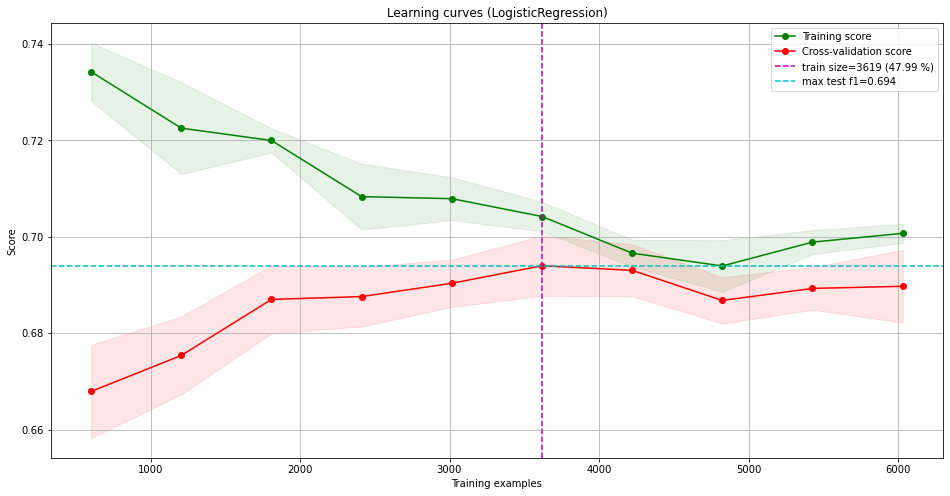

output <= list(3):
  [0]:DataFrame(2500, 44)
  [1]:ndarray(2500,)
  [2]:dict(9):
    ['algorithm']:str(3)
    ['model']:GridSearchCV
    ['train']:dict(5):
      ['0']:dict(4):
        ['precision']:float
        ['recall']:float
        ['f1-score']:float
        ['support']:int
      ['1']:dict(4):
        ['precision']:float
        ['recall']:float
        ['f1-score']:float
        ['support']:int
      ['accuracy']:float
      ['macro avg']:dict(4):
        ['precision']:float
        ['recall']:float
        ['f1-score']:float
        ['support']:int
      ['weighted avg']:dict(4):
        ['precision']:float
        ['recall']:float
        ['f1-score']:float
        ['support']:int
    ['test']:dict(5):
      ['0']:dict(4):
        ['precision']:float
        ['recall']:float
        ['f1-score']:float
        ['support']:int
      ['1']:dict(4):
        ['precision']:float
        ['recall']:float
        ['f1-score']:float
        ['support']:int
      ['accuracy']:float
   

In [180]:
grid_params = {
    # 'max_iter': [5, 10, 50, 60, 100, 1000],
    # 'C': [.1, 1, 10, 100, 200, 1000]
    'max_iter': [100],
    'C': [.1]
    }

cv = StratifiedKFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)

results = pipeline(
    {
        # 0: бекап датасетов
        'copy_dfs': copy_dfs,

        # 1: заполнение NaN датасетов 0
        'fillna_dfs': fillna_dfs,

        # 1: заполнение NaN датасетов median()/value_counts().idxmax()
        # 'fillna_medians_dfs': fillna_medians_dfs,
        
        # 2: преобразование категориальных признаков в вещественные: get_dummies()
        'get_dummies_dfs': get_dummies_dfs,
        
        # 3: балансировка методом 'smote'
        'balance_df_train': balance_df_train,
        
        # 4: разбиение обучающего датасета на X и y
        'split_dfs_to_X_y': split_dfs_to_X_y,
        
        # 5: разбиение обучающего датасета на обучающую и валидационную выборки
        'split_X_y_to_train_valid': split_X_y_to_train_valid,
        
        # 6: масштабирование данных (стандартизация)
        'scale_X_train_valid_test': scale_X_train_valid_test,
        
        # 7 обучение, предсказание модели и получение метрик
        'fit_predict_estimate': fit_predict_estimate
    },
    inputs={
        # бекап датасетов
        'copy_dfs': [
                     df_train,
                     df_test
                     ],
        # заполнение NaN датасетов 0
        'fillna_dfs': {
            'method': 0
            # 'num_features': list(set(NAN_FEATURES) - set(CAT_FEATURES)),
            # 'cat_features': list(set(NAN_FEATURES) - set(NUM_FEATURES))},
            },
        # преобразование категориальных признаков в вещественные: get_dummies()
        'get_dummies_dfs': {
            'target': TARGET
            },
        # балансировка методом 'smote'
        'balance_df_train': {
            'target': TARGET,
            'method': 'smote',
            'balancing_threshold': 0.7,
            'k_neighbors': 5,
            'random_state': RANDOM_STATE,
            'shuffle': True,
            'silent': True
            },
        # разбиение обучающего датасета на X и y
        'split_dfs_to_X_y': {
            'target': TARGET,
            'columns_to_test': True
            },
        # разбиение обучающего датасета на обучающую и валидационную выборки
        'split_X_y_to_train_valid': {
            'test_size': 0.3,
            'shuffle': True,
            'random_state': RANDOM_STATE
            },
        # масштабирование данных (стандартизация)
        'scale_X_train_valid_test': {
            'scaler': StandardScaler()
            },
        # обучение, предсказание модели и получение метрик
        'fit_predict_estimate': {
            'estimator': GridSearchCV(
                estimator=LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1),
                param_grid=grid_params, scoring=SCORING,
                cv=cv, verbose=2, n_jobs=-1),
            'algorithm': 'LOR',
            'models': MODELS,
            'model_file_name': None,
            'scoring': SCORING,
            'silent': False,
            'learning_curve_train_sizes': np.linspace(.1, 1., 10)
            }
    },
    silent=False)

# Сохранение результатов в общем словаре результатов
RESULTS[len(RESULTS)] = results[-1]

In [181]:
# Отчет с результатами
# Kaggle Submissions #1 Score: F1=0.53906
print(results[-1]['report'])

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.74      0.71      3709
           1       0.72      0.67      0.70      3832

    accuracy                           0.70      7541
   macro avg       0.71      0.70      0.70      7541
weighted avg       0.71      0.70      0.70      7541

TEST

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1678
           1       0.70      0.68      0.69      1555

    accuracy                           0.70      3233
   macro avg       0.70      0.70      0.70      3233
weighted avg       0.70      0.70      0.70      3233

CONFUSION MATRIX

col_0              0     1
Credit Default            
0               1217   461
1                494  1061


## Результаты, проведенные на базовой модели.   


Вариант 1. Baseline LogisticRegression(n_jobs=-1, random_state=42).   
 1. Заполнение NaN: fillna(method='ffill')/fillna(method='bfill').  
 2. Категории в вещественные: groupby(feature).size().  
F1         = 0.3653395784543325  
Precision  = 0.7959183673469388  
Recall     = 0.23708206686930092  

---

Вариант 2. Baseline LogisticRegression(n_jobs=-1, random_state=42).  
 1. Заполнение NaN: 0.  
 2. Категории в вещественные: get_dummies.  
F1         = 0.44249726177437027  
Precision  = 0.792156862745098  
Recall     = 0.3069908814589666  

---

Вариант 3. Baseline LogisticRegression(n_jobs=-1, random_state=42).  
 1. Заполнение NaN: fillna(method='ffill')/fillna(method='bfill').
 2. Категории в вещественные: get_dummies.  
F1         = 0.39407744874715267  
Precision  = 0.7863636363636364  
Recall     = 0.2629179331306991  

---

Вариант 4. Baseline LogisticRegression(n_jobs=-1, random_state=42).  
 1. Заполнение NaN: median()/value_counts().idxmax().  
 2. Категории в вещественные: get_dummies.  
F1         = 0.4150513112884835  
Precision  = 0.8310502283105022  
Recall     = 0.2765957446808511  

---

Вариант 5. Baseline LogisticRegression(n_jobs=-1, random_state=42).  
 1. Заполнение NaN: 0.  
 2. Категории в вещественные: get_dummies.  
 3. balance_df_by_multiclass_target(df_train_, TARGET, 'adasyn', k_neighbors=5, random_state=42, silent=False).  
F1         = 0.6725476358503882  
Precision  = 0.705925925925926  
Recall     = 0.6421832884097035  

---

Вариант 6. Baseline LogisticRegression(n_jobs=-1, random_state=42).  
 1. Заполнение NaN: median()/value_counts().idxmax().  
 2. Категории в вещественные: get_dummies.  
 3. balance_df_by_multiclass_target(df_train_, TARGET, 'adasyn', k_neighbors=5, random_state=42, silent=False).  
F1         = 0.6524102935846322  
Precision  = 0.7131537242472267  
Recall     = 0.6012024048096193  

---

Вариант 7. Baseline LogisticRegression(n_jobs=-1, random_state=42).  
 1. Заполнение NaN: 0.  
 2. Категории в вещественные: get_dummies.  
 3. balance_df_by_multiclass_target(df_train_, TARGET, 'smote', k_neighbors=5, random_state=42, silent=False).  
F1         = 0.6900129701686122  
Precision  = 0.6958796599084369  
Recall     = 0.6842443729903537  

---

Вариант 8. Baseline LogisticRegression(n_jobs=-1, random_state=42).  
 1. Заполнение NaN: median()/value_counts().idxmax().  
 2. Категории в вещественные: get_dummies.  
 3. balance_df_by_multiclass_target(df_train_, TARGET, 'smote', k_neighbors=5, random_state=42, silent=False).  
F1         = 0.6826826826826827  
Precision  = 0.7094313453536755  
Recall     = 0.6578778135048231  

---

Вариант 9. Baseline LogisticRegression(n_jobs=-1, random_state=42).  
 1. Заполнение NaN: 0.  
 2. Категории в вещественные: get_dummies.  
 3. balance_df_by_multiclass_target(df_train_, TARGET, 'smotetomek', k_neighbors=5, random_state=42, silent=False).  
F1         = 0.6877168632893824  
Precision  = 0.7368029739776951  
Recall     = 0.6447625243981783  

---

Вариант 10. Baseline LogisticRegression(n_jobs=-1, random_state=42).  
 1. Заполнение NaN: median()/value_counts().idxmax().  
 2. Категории в вещественные: get_dummies.  
 3. balance_df_by_multiclass_target(df_train_, TARGET, 'smotetomek', k_neighbors=5, random_state=42, silent=False).  
F1         = 0.6825396825396826  
Precision  = 0.7256052824651504  
Recall     = 0.644299674267101  

---

Вариант 11. Baseline LogisticRegression(n_jobs=-1, random_state=42).  
 1. Заполнение NaN: fillna(method='ffill')/fillna(method='bfill').  
 2. Категории в вещественные: get_dummies.  
 3. balance_df_by_multiclass_target(df_train_, TARGET, 'smotetomek', k_neighbors=5, random_state=42, silent=False).  
F1         = 0.6636458696409899  
Precision  = 0.7152516904583021  
Recall     = 0.6189856957087126  

---


# Подбор финальной модели

In [182]:
# Словарь с порогами для выбросов
# 'Annual Income': 1.1e+7
# 'Months since last delinquent': 100.0
# 'Bankruptcies': 5.0
# 'Credit Score': 1000 (7600)
# thresholds = {'Annual Income': 6.0, 'Months since last delinquent': 3.0, 'Bankruptcies': 7, 'Credit Score': 2.0} # с масштабированием
# thresholds = {'Annual Income': 1.1e+7, 'Months since last delinquent': 100, 'Bankruptcies': 5.0, 'Credit Score': 1000} # без масштабирования


[ *** job: #000 function:                      copy_dfs                      *** ]
input => list(2):
  [0]:DataFrame(7500, 17)
  [1]:DataFrame(2500, 16)
output <= list(2):
  [0]:DataFrame(7500, 17)
  [1]:DataFrame(2500, 16)

[ *** job: #001 function:              fill_dfs_outliers_to_na               *** ]
input => list(2):
  [0]:DataFrame(7500, 17)
  [1]:DataFrame(2500, 16)
output <= list(2):
  [0]:DataFrame(7500, 17)
  [1]:DataFrame(2500, 16)

[ *** job: #002 function:                  get_dummies_dfs                   *** ]
input => list(2):
  [0]:DataFrame(7500, 17)
  [1]:DataFrame(2500, 16)

	ВНИМАНИЕ!!! Для работоспособности XGBoost в выходном 0-ом датафрейме производится замена имен столбцов:
		 * 'Years in current job_10+ years' -> 'Years in current job_10_plus_years'
		 * 'Years in current job_< 1 year ' -> 'Years in current job__lt_1 year   '

	ВНИМАНИЕ!!! Для работоспособности XGBoost в выходном 1-ом датафрейме производится замена имен столбцов:
		 * 'Years in current job_1

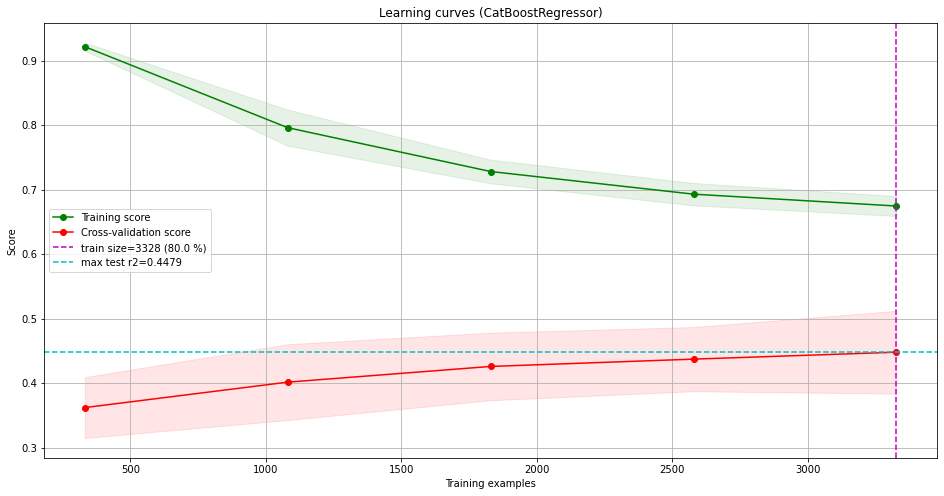

3328 0.44788910943424903
Fitting target 'Months since last delinquent' on model 'CatBoostRegressor'...
target: 'Months since last delinquent', model: CatBoostRegressor
r2 train: 0.34887967897363203
r2 test:  0.014295438994943899


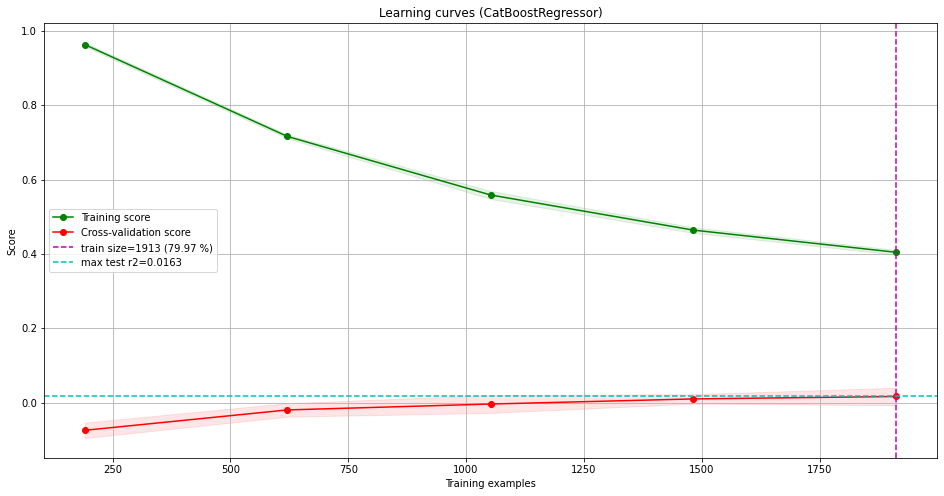

1913 0.016345994319757362
Fitting target 'Bankruptcies' on model 'CatBoostRegressor'...
target: 'Bankruptcies', model: CatBoostRegressor
r2 train: 0.9548146297800355
r2 test:  0.7437611844673109


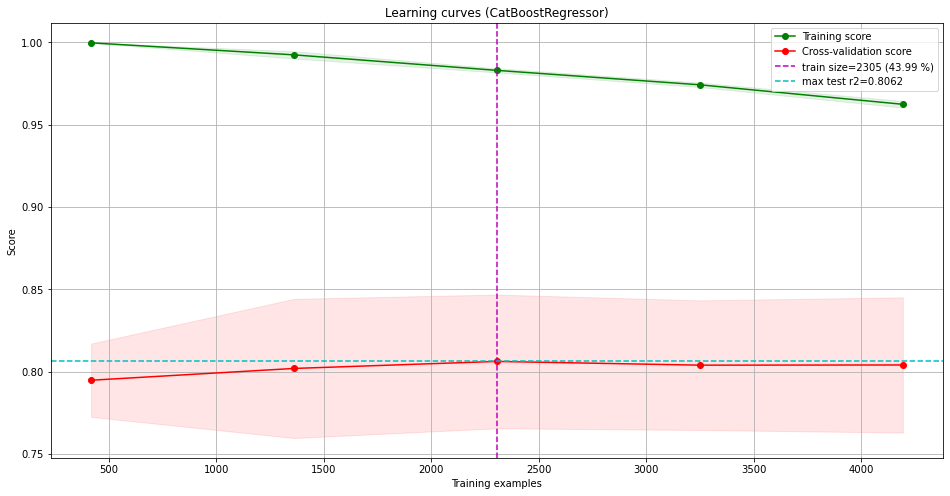

2305 0.8061728432118065
Fitting target 'Credit Score' on model 'CatBoostRegressor'...
target: 'Credit Score', model: CatBoostRegressor
r2 train: 0.5841744728866918
r2 test:  0.318379340666028


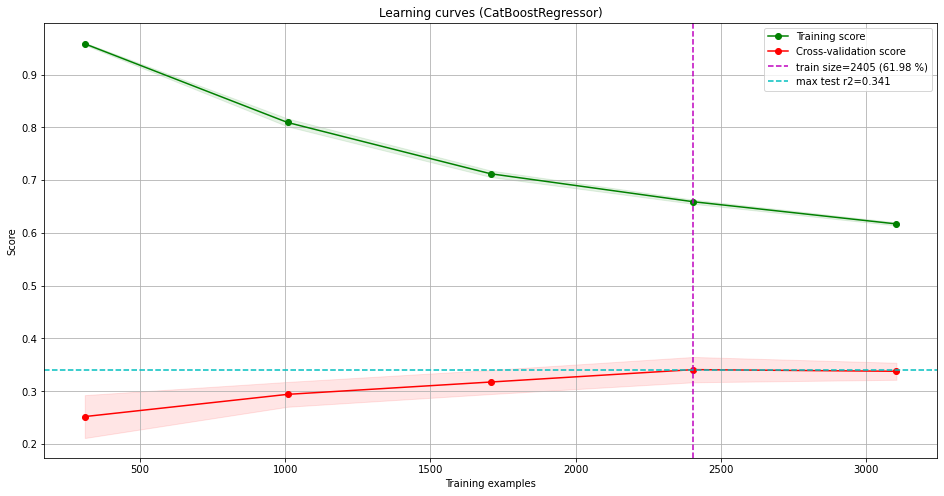

2405 0.341004352519494
Fitting target 'Annual Income' on model 'CatBoostRegressor'...
target: 'Annual Income', model: CatBoostRegressor
r2 train: 0.7460030062106251
r2 test:  0.4527890614941469


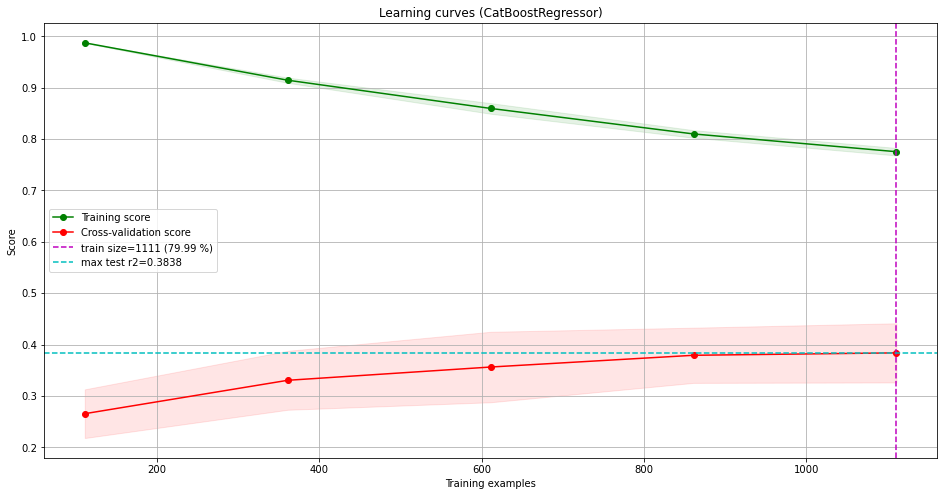

1111 0.3838144645876541
Fitting target 'Months since last delinquent' on model 'CatBoostRegressor'...
target: 'Months since last delinquent', model: CatBoostRegressor
r2 train: 0.6003881506999436
r2 test:  -0.0061818119237555536


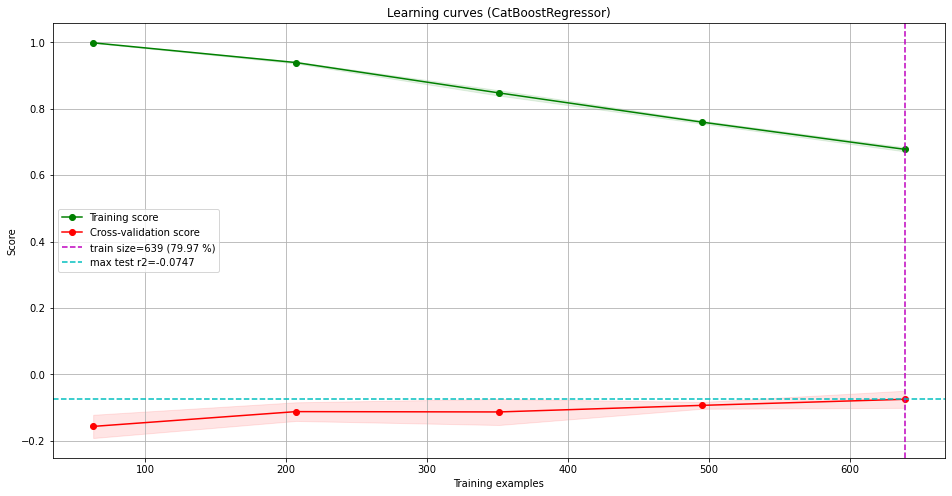

639 -0.0747047702941936
Fitting target 'Bankruptcies' on model 'CatBoostRegressor'...
target: 'Bankruptcies', model: CatBoostRegressor
r2 train: 0.9941341872050463
r2 test:  0.7302368498271068


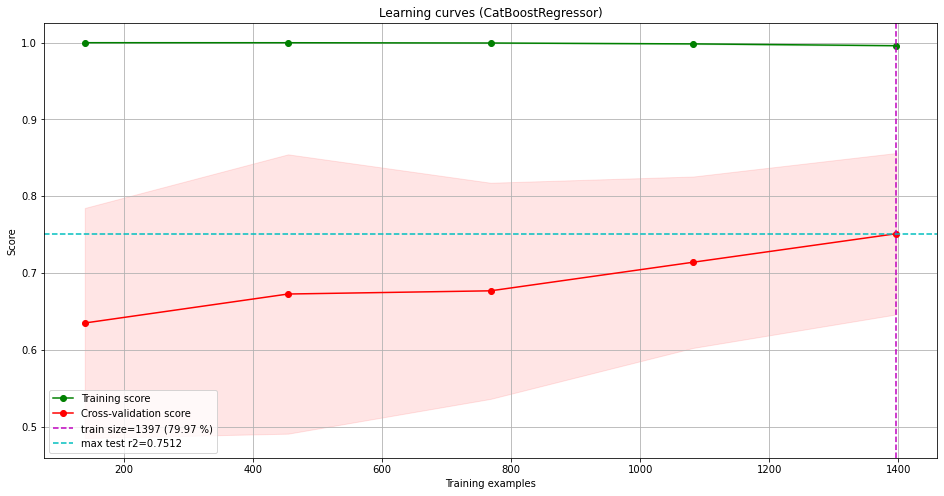

1397 0.7511883213199513
Fitting target 'Credit Score' on model 'CatBoostRegressor'...
target: 'Credit Score', model: CatBoostRegressor
r2 train: 0.752324570698506
r2 test:  0.2825936881602359


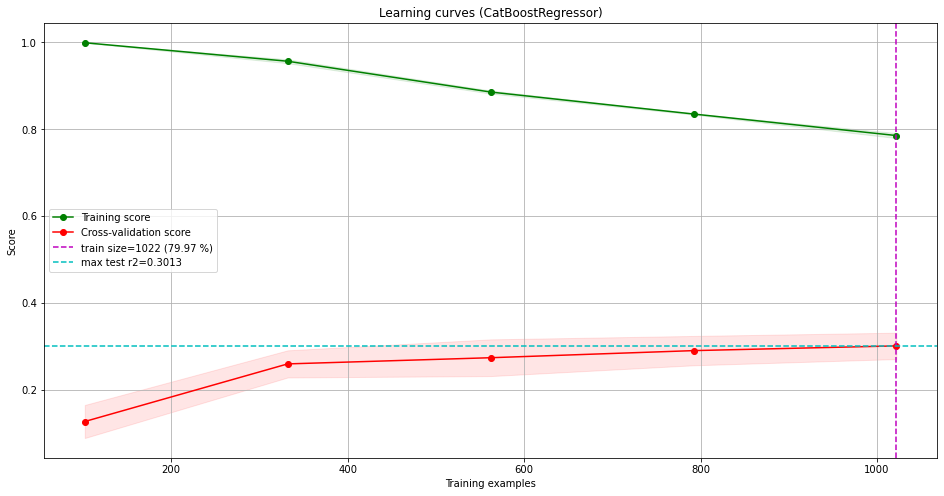

1022 0.3013266841720406
output <= list(2):
  [0]:DataFrame(7500, 45)
  [1]:DataFrame(2500, 43)

[ *** job: #004 function:                  balance_df_train                  *** ]
input => list(2):
  [0]:DataFrame(7500, 45)
  [1]:DataFrame(2500, 43)
output <= list(2):
  [0]:DataFrame(10774, 46)
  [1]:DataFrame(2500, 43)

[ *** job: #005 function:                  split_dfs_to_X_y                  *** ]
input => list(2):
  [0]:DataFrame(10774, 46)
  [1]:DataFrame(2500, 43)

	ВНИМАНИЕ!!! Удаляются отличительные признаки (столбцы) во входных 0-ом и 1-ом датафреймах X_train и X_test:
		 * 'index'
		 * 'Credit Default'
		 * 'Purpose_renewable energy'
output <= list(3):
  [0]:DataFrame(10774, 43)
  [1]:Series(10774,)
  [2]:DataFrame(2500, 43)

[ *** job: #006 function:              split_X_y_to_train_valid              *** ]
input => list(3):
  [0]:DataFrame(10774, 43)
  [1]:Series(10774,)
  [2]:DataFrame(2500, 43)
output <= list(5):
  [0]:DataFrame(7541, 43)
  [1]:DataFrame(3233, 43)
  [2]:S

In [183]:
# Предобработка данных перед обучением, предсказанием, сохранением результатов

version_data='0'

grid_params = {
    'max_iter': [5, 10, 50, 60, 100, 200, 500, 1000],
    'C': [.001, .01, .1, 1, 10, 100, 200, 1000, 10000]
    }

cv = StratifiedKFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)

results = pipeline(
    {
        # 0: бекап датасетов
        'copy_dfs': copy_dfs,

        # 1: заполнение выбросов на NaN
        'fill_dfs_outliers_to_na': fill_dfs_outliers_to_na,

        # 2/3: преобразование категориальных признаков в вещественные: get_dummies()
        'get_dummies_dfs': get_dummies_dfs,

        # 3/2: заполнение NaN датасетов с помощью обученных моделей
        'fillna_by_fitted_models_r2': fillna_by_fitted_models,

        # 4/2: заполнение NaN датасетов с помощью обученных моделей
        # 'fillna_by_fitted_models_f1': fillna_by_fitted_models,

        # 5: балансировка (метод 'smote' - только после заполнения NaN)
        'balance_df_train': balance_df_train,

        # 6: разбиение обучающего датасета на X и y
        'split_dfs_to_X_y': split_dfs_to_X_y,

        # 7: разбиение обучающего датасета на обучающую и валидационную выборки
        'split_X_y_to_train_valid': split_X_y_to_train_valid,

        # 8: масштабирование данных (стандартизация)
        'scale_X_train_valid_test': scale_X_train_valid_test,
    },
    inputs={
        # бекап датасетов
        'copy_dfs': [
                     df_train,
                     df_test
                     ],
        # заполнение NaN датасетов 0
        'fill_dfs_outliers_to_na': {
            'thresholds': {
                'Annual Income': 1.1e+7,
                'Months since last delinquent': 100,
                'Bankruptcies': 5.0,
                'Credit Score': 1000},
            'is_quantile': False
            },
        # преобразование категориальных признаков в вещественные: get_dummies()
        'get_dummies_dfs': {
            'target': TARGET
            },
        # заполнение NaN датасетов с помощью обученных моделей
        'fillna_by_fitted_models_r2': {
            # 'scaler': None,
            'scaler': StandardScaler(),
            'fitted_models': {
                'Annual Income': MODELS_PATH + 'Annual_Income_model_CBR.pkl',
                'Months since last delinquent': MODELS_PATH + 'Months_since_last_delinquent_model_CBR.pkl',
                'Bankruptcies': MODELS_PATH + 'Bankruptcies_model_CBR.pkl',
                'Credit Score': MODELS_PATH + 'Credit_Score_model_CBR.pkl'},
            'shuffle': True,
            'no_fit': False,
            'silent': False,
            'model_file_name': None,
            'scoring': 'r2'
            },
        # заполнение NaN датасетов с помощью обученных моделей
        # 'fillna_by_fitted_models_f1': {
        #     # 'scaler': None,
        #     'scaler': StandardScaler(),
        #     'fitted_models': {
        #         'Annual Income': './models/Annual_Income_model_CBR.pkl',
        #     'silent': False,
        #     'model_file_name': None,
        #     'scoring': 'f1'
        #     },
        # балансировка методом 'smote'
        'balance_df_train': {
            'target': TARGET,
            'method': 'smote',
            'balancing_threshold': 0.7,
            'k_neighbors': 5,
            'shuffle': True,
            'random_state': RANDOM_STATE,
            'silent': True
            },
        # разбиение обучающего датасета на X и y
        'split_dfs_to_X_y': {
            'target': TARGET,
            'columns_to_test': True
            },
        # разбиение обучающего датасета на обучающую и валидационную выборки
        'split_X_y_to_train_valid': {
            'test_size': 0.3,
            'shuffle': True,
            'random_state': RANDOM_STATE
            },
        # масштабирование данных (стандартизация)
        'scale_X_train_valid_test': {
            'scaler': StandardScaler()
            }
    },
    silent=False)

# Сохранение данных до обучения и предсказания в файлы
# save_data(results, OUT_DATA_PATH + f'data_before_predict_{version_data}_.zip')

In [184]:
# # Загрузка данных до обучения и предсказания из файлов
# results = load_data(*(OUT_DATA_PATH + 'data_before_predict_0_000.zip',
#                       OUT_DATA_PATH + 'data_before_predict_0_001.zip',
#                       OUT_DATA_PATH + 'data_before_predict_0_002.zip',
#                       OUT_DATA_PATH + 'data_before_predict_0_003.zip',
#                       OUT_DATA_PATH + 'data_before_predict_0_004.zip'))

In [185]:
results[1]

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,-0.394959,-0.124778,1.630831,0.362617,0.003311,-0.356538,0.074667,-0.34463,-0.296653,1.086170,...,-0.070588,-0.105499,-0.039559,-0.329671,-0.062883,-0.071895,-0.029523,-0.038461,1.598157,-1.598157
1,-0.017392,-0.124778,-0.886308,-0.566805,-0.030659,-0.356538,-1.298956,-0.34463,3.358763,-0.042617,...,-0.070588,-0.105499,-0.039559,-0.329671,-0.062883,-0.071895,-0.029523,-0.038461,-0.685857,0.685857
2,-1.265699,-0.124778,-0.283725,-1.003792,-0.020467,-0.356538,0.589478,-0.34463,-0.305764,-0.430332,...,-0.070588,-0.105499,-0.039559,-0.329671,-0.062883,-0.071895,-0.029523,-0.038461,-0.685857,0.685857
3,0.402278,-0.124778,1.853172,0.453203,0.059967,-0.356538,-0.149250,-0.34463,-0.297429,2.140292,...,-0.070588,-0.105499,-0.039559,-0.329671,-0.062883,-0.071895,-0.029523,-0.038461,0.698248,-0.698248
4,0.083602,-0.124778,-1.515592,-0.203750,-0.045311,-0.356538,-0.192118,-0.34463,-0.292306,-0.456620,...,-0.070588,-0.105499,-0.039559,3.376802,-0.062883,-0.071895,-0.029523,-0.038461,-0.685857,0.685857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,-0.233797,7.555043,-1.096069,0.885417,-0.032800,3.867907,-1.230131,-0.34463,-0.297922,-0.127939,...,-0.070588,-0.105499,-0.039559,-0.329671,-0.062883,-0.071895,-0.029523,-0.038461,-0.685857,0.685857
3229,-0.434011,-0.124778,-0.676546,-0.116616,-0.042087,-0.356538,0.291316,-0.34463,3.358763,-0.464360,...,-0.070588,-0.105499,-0.039559,-0.329671,-0.062883,-0.071895,-0.029523,-0.038461,-0.685857,0.685857
3230,0.154568,-0.124778,1.001547,0.217395,0.053754,-0.356538,-0.662593,-0.34463,-0.301114,-0.108466,...,-0.070588,-0.105499,-0.039559,-0.329671,-0.062883,-0.071895,-0.029523,-0.038461,-0.685857,0.685857
3231,-0.281323,-0.124778,0.372262,-0.784639,-0.033664,-0.356538,-0.060107,-0.34463,-0.301070,-0.290033,...,-0.070588,-0.105499,-0.039559,-0.329671,-0.062883,-0.071895,-0.029523,-0.038461,-0.685857,0.685857


In [186]:
#  OUT_CSV.replace('ALG', algorithm)

In [187]:
# УДАЛИТЬ!!!!!!!!!!!!!!!!!!!!!!!
# results = dfs_results.copy()

In [188]:
# save_out_predictions(results[1], 'gb-credit-default_predictions_LOR.csv')

In [189]:
# !pip show pandas

In [190]:
# save_out_predictions(results[1], OUT_CSV.replace('ALG', algorithm))

In [191]:
# ВНИМАНИЕ!!! Выполняется долго!!!
# Поиск наилучших финальных моделей
# %%time

# Копирование предыдущих результатов
dfs_results = results.copy()

cv = StratifiedKFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)

cls_models = {
    'LOR': LogisticRegression(n_jobs=-1, random_state=RANDOM_STATE),
    # 'PTC': Perceptron(n_jobs=-1, random_state=RANDOM_STATE, early_stopping=True,
    #                   verbose=0, validation_fraction=.05),
    'RGC': RidgeClassifier(random_state=RANDOM_STATE),
    'SGC': SGDClassifier(n_jobs=-1, random_state=RANDOM_STATE, early_stopping=True,
                      verbose=0, validation_fraction=.05),
    'KNC': KNeighborsClassifier(n_jobs=-1),
    # 'RNC': RadiusNeighborsClassifier(n_jobs=-1),
    # 'SVC': SVC(random_state=RANDOM_STATE, verbose=False),
    'DTC': DecisionTreeClassifier(random_state=RANDOM_STATE),
    # 'ETC': ExtraTreeClassifier(random_state=RANDOM_STATE),
#     'ABC': AdaBoostClassifier(random_state=RANDOM_STATE),
    'RFC': RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE, verbose=0),
    # 'GBC': GradientBoostingClassifier(random_state=RANDOM_STATE, verbose=0),
    # 'XBC': XGBClassifier(verbosity=0, n_jobs=-1, random_state=RANDOM_STATE),
    'XFC': XGBRFClassifier(verbosity=0, n_jobs=-1, random_state=RANDOM_STATE),
#     'LBC': LGBMClassifier(silent=True, n_jobs=-1, random_state=RANDOM_STATE),
    'CBC': CatBoostClassifier(verbose=None, random_seed=RANDOM_STATE,#cat_features=CAT_FEATURES,
                             eval_metric='F1', early_stopping_rounds=20),
#     'BAC': BaggingClassifier(n_jobs=-1, random_state=RANDOM_STATE, verbose=0),
    'STC': StackingClassifier(n_jobs=-1, verbose=0, estimators=None)
    }

cls_models_grid_params = {
    'LOR': {'C': [0.01], 'max_iter': [35], 'penalty': ['l1'], 'solver': ['liblinear']},
    # best params: {'C': 0.01, 'max_iter': 50, 'penalty': 'l1', 'solver': 'liblinear'}
    # (f1 train: 0.7322900489786167, f1 test:  0.7088462639564844)
    # best params: {'C': 0.01, 'max_iter': 35, 'penalty': 'l1', 'solver': 'liblinear'}
    # (f1 train: 0.7333811573409852, f1 test:  0.7106540988289061)
        # {
        # 'max_iter': [5, 10, 50, 60, 100, 200, 500, 1000],
        # 'C': [.001, .01, .1, 1, 10, 100, 200, 1000, 10000],
        # 'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        # 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
        # },
    'PTC': {'alpha': [.01], 'max_iter': [9], 'penalty': ['l1']},
    # best params: {'alpha': 0.01, 'max_iter': 10, 'penalty': 'l1'}
    # (f1 train: 0.7123338600241659, f1 test:  0.6862312444836716)
    # best params: {'alpha': 0.01, 'max_iter': 9, 'penalty': 'l1'}
    # (f1 train: 0.7137511693171188, f1 test:  0.6870431893687707)
        # {
        # 'max_iter': [5, 10, 50, 60, 100, 200, 500, 1000, 2000],
        # 'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1],
        # 'penalty': ['l2', 'l1', 'elasticnet', None]
        # },
    'RGC': {'alpha': [0.0001], 'max_iter': [4], 'solver': ['sag']},
    # best params: {'alpha': 0.0001, 'max_iter': 5, 'solver': 'sag'}
    # (f1 train: 0.7173131738753254, f1 test:  0.6933333333333335)
    # best params: {'alpha': 0.0001, 'max_iter': 4, 'solver': 'sag'}
    # (f1 train: 0.7226686145605065, f1 test:  0.7011695906432748)
        # {
        # 'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 10],
        # 'max_iter': [None, 5, 10, 50, 60, 100, 200, 500, 1000],
        # 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
        # },
    'SGC': {'alpha': [0.1], 'loss': ['log'], 'max_iter': [10], 'penalty': ['l1']},
    # best params: {'alpha': 0.1, 'loss': 'log', 'max_iter': 10, 'penalty': 'l1'}
    # (f1 train: 0.7362146050670642, f1 test:  0.7080231596360629)
    # best params: {'alpha': 0.10368421052631578, 'loss': 'log', 'max_iter': 6, 'penalty': 'l1'}
    # (f1 train: 0.7381466742467311, f1 test:  0.7074235807860262)
        # {
        # 'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
        # 'penalty': ['l2', 'l1', 'elasticnet'],
        # 'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
        # 'max_iter': [5, 10, 50, 100, 1000, 2000]
        # },
    'KNC': {'algorithm': ['auto'], 'metric': ['euclidean'], 'n_neighbors':[3], 'p': [1]},
    # best params: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 3, 'p': 1}
    # (f1 train: 0.8876418824129576, f1 test:  0.7421461897356143)
    # best params: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 1, 'p': 1}
    # (f1 train: 1.0, f1 test:  0.7657630216265611)
        # {
        # 'n_neighbors': [3, 4, 5, 6, 7],
        # 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        # 'p': [1, 2],
        # 'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
        # },
    'RNC': {
        'radius': [.1, 1, 5, 10],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'p': [1, 2],
        'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
        },
    'SVC': {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
        'degree': [2, 3, 4],
        'C': [1e-5, 1e-4, 1e-3, 1e-2, .1, 1, 10, 100, 1000],
        'max_iter': [-1, 5, 10, 50, 100, 1000]
        },
    'DTC': {'ccp_alpha': [0], 'criterion': ['gini'], 'max_depth': [None], 'max_features': [0.3], 'min_samples_leaf': [0.3], 'splitter': ['best']},
    # best params: {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.3, 'min_samples_leaf': 0.3, 'splitter': 'best'}
    # (f1 train: 0.711168769902111, f1 test:  0.685419058553387)
    # best params: {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.2, 'min_samples_leaf': 0.2, 'splitter': 'best'}
    # (f1 train: 0.7120604201085674, f1 test:  0.685222381635581)
        # {
        # 'criterion': ['gini', 'entropy'],
        # 'splitter': ['best', 'random'],
        # 'max_depth': [None, 2, 3, 4, 5, 6, 7],
        # 'min_samples_leaf': [.3, .5, 1],
        # 'max_features': [.3, .5, 1],
        # 'ccp_alpha': [0, 1e-4, 1e-2, .1, .5, 1, 10, 50]
        # },
    'ETC': {'ccp_alpha': [0], 'criterion': ['gini'], 'max_depth': [None], 'max_features': [0.3], 'min_samples_leaf': [0.3], 'splitter': ['best']},
    # best params: {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.3, 'min_samples_leaf': 0.3, 'splitter': 'best'}
    # (f1 train: 0.711168769902111, f1 test:  0.685419058553387)
    # best params: {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.2, 'min_samples_leaf': 0.2, 'splitter': 'best'}
    # (f1 train: 0.7120604201085674, f1 test:  0.685222381635581)
        # {
        # 'criterion': ['gini', 'entropy'],
        # 'splitter': ['best', 'random'],
        # 'max_depth': [None, 2, 3, 4, 5, 6, 7],
        # 'min_samples_leaf': [.3, .5, 1],
        # 'max_features': [.3, .5, 1],
        # 'ccp_alpha': [0, 1e-4, 1e-2, .1, .5, 1, 10, 50 ]
        # },
    'ABC': {'learning_rate': [1], 'n_estimators': [200]},
    # best params: {'learning_rate': 1, 'n_estimators': 200}
    # (f1 train: 0.8183431145079841, f1 test:  0.794601711652403)
    # best params: {'learning_rate': 0.6394736842105264, 'n_estimators': 195}
    # (f1 train: 0.8114316239316238, f1 test:  0.7927578402845133)
    # best params: {'learning_rate': 0.6394736842105264, 'n_estimators': 230}
    # (f1 train: 0.8148148148148148, f1 test:  0.7910302242443941)
    # best params: {'learning_rate': 0.6684210526315789, 'n_estimators': 230}
    # (f1 train: 0.8118598382749326, f1 test:  0.7907280444009142)
        # {
        # 'n_estimators': [10, 50, 100, 200, 300],
        # 'learning_rate': [1e-3, 1e-2, 1e-1, 1, 10, 100]
        # },
    'RFC': {'ccp_alpha': [0], 'criterion': ['gini'], 'max_depth': [None], 'max_features': [1.0], 'min_samples_leaf': [0.2], 'n_estimators': [10]},
    # best params: {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 0.3, 'n_estimators': 10}
    # (f1 train: 0.6779227423893579, f1 test:  0.6537257357545398)
    # best params: {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 0.2, 'n_estimators': 10}
    # (f1 train: 0.7168660567675345, f1 test:  0.6892816419612314)
        # {
        # 'n_estimators': [10, 50, 100, 200, 300],
        # 'criterion': ['gini', 'entropy'],
        # 'max_depth': [None, 2, 3, 4, 5, 6, 7],
        # 'min_samples_leaf': [.3, .5, 1],
        # 'max_features': [.3, .5, 1],
        # 'ccp_alpha': [0, 1e-4, 1e-2, .1, .5, 1, 10, 50]
        # },
    'GBC': {'ccp_alpha': [0], 'learning_rate': [0.27], 'loss': ['exponential'], 'max_depth': [7], 'max_features': [0.3], 'n_estimators': [200]},
    # best params: {'ccp_alpha': 0, 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 7, 'max_features': 0.3, 'n_estimators': 200}
    # (f1 train: 0.9885571484940155, f1 test:  0.8089363121040346)
    # best params: {'ccp_alpha': 0, 'learning_rate': 0.2705263157894737, 'loss': 'exponential', 'max_depth': 7, 'max_features': 0.3, 'n_estimators': 200}
    # (f1 train: 1.0, f1 test:  0.8124585818422797)
        # {
        # 'loss': ['deviance', 'exponential'],
        # 'n_estimators': [10, 50, 100, 200],
        # 'max_depth': [2, 3, 4, 5, 6, 7],
        # 'learning_rate': [1e-3, 1e-2, 1e-1, 1],
        # 'max_features': [.3, .5, 1],
        # # 'min_samples_leaf': [.3, .5, 1],
        # # 'criterion': ['mse', 'friedman_mse', 'mae'],
        # 'ccp_alpha': [0, 1e-4, 1e-2, .1, 1, 10, 50]
        # },
    'XBC': {'booster': ['gbtree'], 'learning_rate': [0.1], 'max_depth': [7], 'n_estimators': [500], 'reg_lambda': [5]},
    # best params: {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'reg_lambda': 5}
    # (f1 train: 0.9983008757025225, f1 test:  0.8061088977423639)
    # {
    #     'n_estimators': [10, 50, 100, 200, 500],
    #     'learning_rate': [1e-3, 1e-2, 1e-1, 1],
    #     'max_depth': [2, 3, 4, 5, 6, 7],
    #     # 'reg_alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10],
    #     'reg_lambda': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10],
    #     'booster': ['gbtree', 'gblinear', 'dart']
    #     },
    'XFC': {'booster': ['gbtree'], 'learning_rate': [0.001], 'max_depth': [7], 'n_estimators': [500], 'reg_lambda': [0.1]},
    # best params: {'booster': 'gbtree', 'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 500, 'reg_lambda': 0.1}
    # (f1 train: 0.806745182012848, f1 test:  0.7610103626943006)
        # {
        # 'n_estimators': [10, 50, 100, 200, 500],
        # 'learning_rate': [1e-3, 1e-2, 1e-1, 1],
        # 'max_depth': [2, 3, 4, 5, 6, 7],
        # # 'reg_alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10],
        # 'reg_lambda': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10],
        # 'booster': ['gbtree', 'gblinear', 'dart']
        # },
    'LBC': {'boosting_type': ['gbdt'], 'learning_rate': [0.1], 'max_depth': [7], 'n_estimators': [200], 'reg_lambda': [10]},
    # best params: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'reg_lambda': 10}
    # (f1 train: 0.9171300691713007, f1 test:  0.8029343114371458)
        # {
        # 'n_estimators': [10, 50, 100, 200, 500],
        # 'learning_rate': [1e-3, 1e-2, .1, 1, 10],
        # 'max_depth': [2, 3, 4, 5, 6, 7],
        # # 'reg_alpha': [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10],
        # 'reg_lambda': [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10],
        # 'boosting_type': ['gbdt', 'goss', 'dart', 'rf']
        # },
    'CBC': {'iterations': [500], 'max_depth': [7], 'reg_lambda': [1e-06]},
    # (f1 train: 0.9703418007713792, f1 test:  0.8111372022811137)
    # best params: {'iterations': 500, 'max_depth': 7, 'reg_lambda': 1e-06}
    # {
    #     'iterations': [10, 50, 100, 200, 500],
    #     'max_depth': [2, 3, 4, 5, 6, 7],
    #     'reg_lambda': [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10],
    #     },
    'BAC': {'base_estimator': [LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                                              importance_type='split', learning_rate=0.1, max_depth=-1,
                                              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                                              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                                              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)],
            'n_estimators': [200]},
    # (f1 train: 0.9334961997828447, f1 test:  0.816)
    # best params: {'base_estimator': LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
    #             importance_type='split', learning_rate=0.1, max_depth=-1,
    #             min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
    #             n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
    #             random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
    #             subsample=1.0, subsample_for_bin=200000, subsample_freq=0), 'n_estimators': 200}
        # {
        # 'base_estimator': list(cls_models.values())[:-2],
        # 'n_estimators': [10, 50, 100, 200, 500],
        # },
    'STC': {
        'final_estimator': [cls_models['CBC']],
        'stack_method': ['auto', 'predict_proba', 'decision_function', 'predict'],
        },
    }

# Установка параметра estimators для модели StackingClassifier
cls_models['STC'].__dict__['estimators'] = get_stacking_estimators(
    {k:cls_models[k] for k in cls_models.keys() - ['BAC', 'STC', 'CBC']},
    copy.deepcopy(cls_models_grid_params))

for algorithm, model in cls_models.items():

    dfs_copy = dfs_results.copy()

    model = GridSearchCV(estimator=model,
                         param_grid=cls_models_grid_params[algorithm],
                         scoring=SCORING,
                         cv=cv,
                         verbose=3,
                         n_jobs=-1)

    print(model)

    # Инициализация имени файла модели
#     model_file_name = MODEL_PKL.replace(
#         'model_', TARGET.replace(' ', '_') + '_model_'
#         ).replace('ALG', algorithm)
    
    # Обучение, предсказание и сохранение модели в файл
    results = fit_predict_estimate(dfs_copy,
                                   estimator=model,
                                   algorithm=algorithm,
                                   models=MODELS,
                                   model_file_name=None,
#                                    model_file_name=model_file_name,
                                   scoring=SCORING,
                                   no_fit=False,
                                   silent=False,
                                   learning_curve_train_sizes=None)

    # Сохранение тестовых данных с ответами в файл
    save_out_predictions(results[1], OUT_CSV.replace('ALG', algorithm))

    # Сохранение результатов в общем словаре результатов
    RESULTS[len(RESULTS)] = results[-1]

# Сохранение словаря с результатами в файл
# save_obj(RESULTS, 'obj/results_dict.pkl')

KeyError: 'CBC'

# Обзор результатов

Сравнение моделей
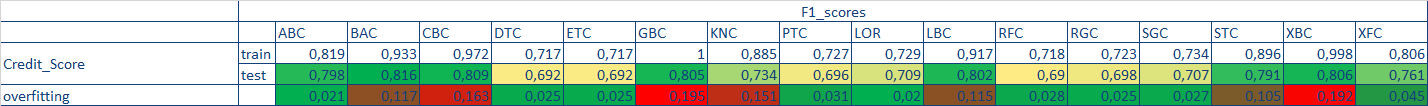

In [ ]:
# Загрузка словаря с результатами из файла
# results_dict = load_obj('obj/results_dict.pkl')
results_dict = RESULTS

In [ ]:
# Обзор значимости признаков в разрезе моделей
x_y_keys_list = [['algorithm'], ['feature_importances']]
df = show_features_importance_bars(results_dict, x_y_keys_list, results[0].columns)
df

In [ ]:
# Обзор метрик некоторых наиболее сильных моделей
x_yy_keys_list = [['algorithm'],
                  ['train', '1', 'f1-score'],
                  ['test', '1', 'f1-score'],
                  ['train', '1', 'precision'],
                  ['test', '1', 'precision'],
                  ['train', '1', 'recall'],
                  ['test', '1', 'recall'],
                  ['train', 'macro avg', 'f1-score'],
                  ['test', 'macro avg', 'f1-score'],
                  ['train', 'weighted avg', 'f1-score'],
                  ['test', 'weighted avg', 'f1-score']]

df_metrics = show_metrics_bars(results_dict, x_yy_keys_list, scoring='f1')
df_metrics

---


# EDA

In [ ]:
# Проверка корреляции между признаками:
df_train.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

In [ ]:
# Распределение целевой переменной
df_train[TARGET].hist(figsize=(8, 8));

In [ ]:
# Требуется балансировка, т.к. коэффициент дисбаланса состовляет менее 0.7
df_train[df_train[TARGET] == 1][TARGET].count() / df_train[df_train[TARGET] == 0][TARGET].count()

In [ ]:
# Распределения вещественных признаков в трейне
df_train[NUM_FEATURES].hist(figsize=(16, 16), bins=50, grid=False);

In [ ]:
# Оценка схожести вещественных признаков в обучающей и тестовой выборках с помощью критерия Манна-Уитни
# for seaborn 0.11.0
p_values = dict()

# for feature in NUM_FEATURES:
for feature in list(set(NUM_FEATURES)-{'Number of Credit Problems', 'Tax Liens', 'Bankruptcies'}):
    stat, pvalue = mannwhitneyu(df_train[feature], df_test[feature])
    p_values[feature] = pvalue
    print(f'Признак: {feature}, p-value = {pvalue}. ', end='')
    if pvalue < ALPHA:
        print('ВНИМАНИЕ!!! Средние в выборках НЕ эквивалентны!')
    
    plt.figure(figsize=(16, 8))
    sns.kdeplot(df_train[feature], shade=True, label='train', color='g')
    sns.kdeplot(df_test[feature], shade=True, label='test', color='r')
    plt.xlabel(TARGET)
    plt.ylabel(feature)
    plt.title(f'Numbers feature: "{feature}" in train and test\n'+
                f'Mann-Whitneyu: p-value = {pvalue} = > Equal: {pvalue > ALPHA}')
    plt.show()

In [ ]:
# 2 признака не прошли проверку соответствия train == test
# 1. Признак: Months since last delinquent, p-value = 1.712573746209761e-82 = > Средние в выборках НЕ эквивалентны!
# 2. Признак: Bankruptcies, p-value = 0.036681545859698156 = > Средние в выборках НЕ эквивалентны!

In [ ]:
p_values

In [ ]:
# Оценка схожести вещественных признаков в разрезе целевой переменной при 'target'=0 и 'target'=1:
# for seaborn 0.11.0
# for feature in NUM_FEATURES:
for feature in list(set(NUM_FEATURES)-{'Number of Credit Problems', 'Tax Liens', 'Bankruptcies'}):
    stat, pvalue = mannwhitneyu(df_train[df_train[TARGET] == 0][feature], df_train[df_train[TARGET] == 1][feature])
    p_values[feature] = pvalue
    print(f'Признак: {feature}, p-value = {pvalue}. ', end='')
    if pvalue < ALPHA:
        print('Средние в выборках НЕ эквивалентны!')

    plt.figure(figsize=(16, 8))
    sns.kdeplot(df_train[df_train[TARGET] == 0][feature], shade=True, label='Нет просрочки', color='g')
    sns.kdeplot(df_train[df_train[TARGET] == 1][feature], shade=True, label='Есть просрочка', color='r')
    # plt.ylim(0, df_train[feature].max() / 2)
    plt.xlabel(feature)
    plt.ylabel(f'Distribution = {df_train[feature].max() / 2}')
    plt.title(f'Numbers feature: "{feature}" for target equals 0 and 1\n'+
                f'Mann-Whitneyu: p-value = {pvalue} = > Equal: {pvalue > ALPHA}')
    plt.show()


In [ ]:
# Оценка схожести вещественных признаков в разрезе целевой переменной при 'target'=0 и 'target'=1:
# for seaborn 0.11.0
if check_module_version(sns.__version__, '0.11.?'):
    for feature in NUM_FEATURES:
        stat, pvalue = mannwhitneyu(df_train[df_train[TARGET] == 0][feature], df_train[df_train[TARGET] == 1][feature])
        p_values[feature] = pvalue
        if pvalue < ALPHA:
            print(f'Признак: {feature}, p-value = {pvalue} = > ', end='')
            print('Средние в выборках НЕ эквивалентны!')

        g1 = sns.displot(x=feature, kde=True, data=df_train[df_train[TARGET] == 0], label='Нет просрочки', color='g')
        g2 = sns.displot(x=feature, kde=True, data=df_train[df_train[TARGET] == 1], label='Есть просрочка', color='r')
        g1.fig.set_size_inches(10, 5)
        g2.fig.set_size_inches(10, 5)
        plt.show()


In [ ]:
g = sns.PairGrid(data=df_train, hue=TARGET)
g.map_upper(sns.scatterplot)
g.map_diag(plt.hist, alpha=0.6)
g.map_lower(sns.kdeplot);

In [ ]:
# Зависимость 'Bankruptcies' / 'Credit Score'
sns.scatterplot(data=df_train, y='Bankruptcies', x='Credit Score', hue=TARGET);

In [ ]:
df_train['Current Loan Amount'].hist(bins=1500)
plt.xlim(0,1000000)
plt.show()

In [ ]:
# Зависимость 'Tax Liens' / 'Current Loan Amount'
sns.scatterplot(data=df_train, y='Tax Liens', x='Current Loan Amount', hue=TARGET);

In [ ]:
# Зависимость 'Maximum Open Credit' / 'Credit Score'
sns.scatterplot(data=df_train, y='Maximum Open Credit', x='Credit Score', hue=TARGET);

In [ ]:
df_train[NUM_FEATURES + [TARGET]]

In [ ]:
# Зависимость 'Current Loan Amount' / 'Credit Score'
sns.scatterplot(data=df_train, y='Current Loan Amount', x='Credit Score', hue=TARGET);
# sns.kdeplot(data=df_train[NUM_FEATURES + [TARGET]], y='Current Loan Amount', x='Credit Score', hue=TARGET);
# sns.kdeplot

In [ ]:
# Оценка 'Annual Income'
df_train.groupby(['Credit Default'])['Annual Income', 'Credit Default'].agg({
    'Annual Income': ['min', 'max', 'mean', 'median'],
    'Credit Default': 'count'
}).reset_index()

In [ ]:
# Оценка схожести и выбросов вещественных признаков в разрезе целевой переменной при 'target'=0 и 'target'=1:
for feature in NUM_FEATURES:
    plt.figure(figsize=(10, 5))
    sns.boxplot(TARGET, feature, data=df_train, palette='rainbow')
    plt.xlabel(TARGET)
    plt.ylabel(feature)
    plt.title(f'{feature}')
    plt.show()

Согласно таблице корреляции вещественный признак 'Credit Score' выявлен, как наиболее значимый. Необходимо провести его анализ для категориальных переменных.

In [ ]:
# Оценка 'Credit Score'
df_train.groupby(['Credit Default'])['Credit Score', 'Credit Default'].agg({
    'Credit Score': ['min', 'max', 'mean', 'median'],
    'Credit Default': 'count'
}).reset_index()

In [ ]:
# Оценка схожести категориальных признаков в разрезе переменной 'Credit Score' для train и test
show_seaborn_pointplot(df_train, df_test, num_feature='Credit Score', cat_features=CAT_FEATURES)

In [ ]:
# Оценка распределения категориальных признаков в разрезе целевой переменной для train и test
for col in CAT_FEATURES:
    plt.figure(figsize=(10, 5))
    sns.pointplot(x=col, y=TARGET, data=df_train, capsize=.1,)
    plt.show();

# Заполнение NaN  
(ввиду долгого выполнения, запуск не рекомендуется - модели уже созданы)

Модель для пропусков/выбросов подбирается для каждого признака индивидуально.  
Модель обучается только на трейне (не на валидации, не на тесте).  
После выбора наилучшей модели для каждого признака (соотношение R2_train~R2_test > 0.75) модель сохраняется.  
В момент валидации и на тесте модель берется для предсказания.

In [ ]:
# # Предобработка данных перед предсказанием признаков с NaN

# # na_to_value - max число из всех признаков с пропусками для временной замены NaN
# na_to_value = 1.5e+7

# grid_params = {
#     'max_iter': [5, 10, 50, 100, 1000],
#     'C': [1e-5, .01, .1, 1, 10, 100]}

# cv = StratifiedKFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)

# results = pipeline(
#     {
#         # 0: бекап датасетов
#         'copy_dfs': copy_dfs,

#         # 1: заполнение NaN датасетов 0
#         'fillna_dfs': fillna_dfs,

#         # 2: преобразование категориальных признаков в вещественные: get_dummies()
#         'get_dummies_dfs': get_dummies_dfs,
     
#         # 3: балансировка методом 'smote'
#         'balance_df_train': balance_df_train,
     
#         # 4: разбиение обучающего датасета на X и y
#         'split_dfs_to_X_y': split_dfs_to_X_y,
     
#         # 5: разбиение обучающей выборки на обучающую и валидационную
#         'split_X_y_to_train_valid': split_X_y_to_train_valid,
#     },
#     inputs={
#         # бекап датасетов
#         'copy_dfs': [
#                      df_train,
#                      df_test
#                      ],
#         # заполнение NaN датасетов 0
#         'fillna_dfs': {
#             'method': na_to_value
#             },
#         # преобразование категориальных признаков в вещественные: get_dummies()
#         'get_dummies_dfs': {
#             'target': TARGET
#             },
#         # балансировка методом 'smote'
#         'balance_df_train': {
#             'target': TARGET,
#             'method': 'smote',
#             'balancing_threshold': 0.7,
#             'k_neighbors': 5,
#             'random_state': RANDOM_STATE,
#             'silent': True
#             },
#         # разбиение обучающего датасета на X и y
#         'split_dfs_to_X_y': {
#             'target': TARGET,
#             'columns_to_test': True
#             },
#         # разбиение обучающей выборки на обучающую и валидационную
#         'split_X_y_to_train_valid': {
#             'test_size': 0.3,
#             'random_state': RANDOM_STATE
#             },
#     },
#     silent=False)

In [ ]:
# # Проверка балансировки train и test
# disbalance = None
# for i, df in enumerate(results):
#     if isinstance(df, pd.Series):
#         if disbalance is None:
#             print(f'train:', end = '\t')
#             disbalance = (results[i]==0).sum() / (results[i]==1).sum()
#         else:
#             print(f'test:', end = '\t')
#         print(f'{(results[i]==0).sum()} - {(results[i]==1).sum()} = ' + \
#             f'{(results[i]==0).sum() / (results[i]==1).sum()}')
# print(f'train disbalance = {disbalance}')

In [ ]:
# (results[0]['Years in current job_15000000_0']==1).sum()

In [ ]:
# Проблемные признаки (столбцы с пропусками) (датасеты: df_train/df_test)
# NAN_FEATURES

In [ ]:
# # Новые проблемные признаки (столбцы с пропусками) (датасеты: results[0]/results[1])
# NEW_NAN_FEATURES = list(set(NAN_FEATURES) - set(['Years in current job'])) + ['Years in current job_15000000_0']
# NEW_NAN_FEATURES

In [ ]:
# # Проверка до (origin train/test) и после (result train/test) после:
# # - заполнения NaN на na_to_value;
# # - get_dummies();
# # - балансировки
# for feature in set(NAN_FEATURES) - set(CAT_FEATURES):
#     print(f'{feature:28s}: '+
#           f'origin train: [ NaN: {df_train[feature].isna().sum():6d}, '+
#           f'max: {df_train[feature].max():12.2f}, '+
#           f'na_to_value: {(df_train[feature]==na_to_value).sum():6d} ], '+
#           f'origin test: [ NaN: {df_test[feature].isna().sum():6d}, '+
#           f'max: {df_test[feature].max():12.2f}, '+
#           f'na_to_value: {(df_test[feature]==na_to_value).sum():6d} ]')
#     print(f'{feature:28s}: '+
#           f'result train: [ NaN: {results[0][feature].isna().sum():6d}, '+
#           f'max: {results[0][feature].max():12.2f}, '+
#           f'na_to_value: {(results[0][feature]==na_to_value).sum():6d} ], '+
#           f'result test: [ NaN: {results[1][feature].isna().sum():6d}, '+
#           f'max: {results[1][feature].max():12.2f}, '+
#           f'na_to_value: {(results[1][feature]==na_to_value).sum():6d} ]')

In [ ]:
# # Построение гистограмм для определения порогов выбросов по оригинальным датафреймам (origin train/test)
# # 'Annual Income': 1.1e+7
# # 'Months since last delinquent': 100.0
# # 'Bankruptcies': 5.0
# # 'Credit Score': 1000.0 (вариант 2: 8000.0)
# for feature in set(NAN_FEATURES) - set(CAT_FEATURES):
#     for i, df in enumerate([df_train, df_test, results[0], results[1]]):
#         label=f'{"origin" if i < 2 else "result"} {"train" if i % 2 == 0 else "test"}'
#         df[feature].hist(bins=50, label=f'{label}: {feature}', figsize=(10,6), alpha=.5, log=True)
#         if i % 2 != 0:
#             if i < 2:
#                 plt.title(f'Origin datasets: {feature}')
#             else:
#                 plt.title(f'Result datasets: {feature}')
#             plt.legend()
#             plt.show()

In [ ]:
# # Оценка 'Credit Score'
# df_train.groupby(['Credit Default'])['Credit Score', 'Credit Default'].agg({
#     'Credit Score': ['min', 'max', 'mean', 'median'],
#     'Credit Default': 'count'
# }).reset_index()

In [ ]:
# # Оценка 'Credit Score'
# df_test['Credit Score'].agg(['min', 'max', 'mean', 'median'])

In [ ]:
# Словарь с порогами для выбросов
# 'Annual Income': 1.1e+7
# 'Months since last delinquent': 100.0
# 'Bankruptcies': 5.0
# 'Credit Score': 1000 (7600)
# thresholds = {'Annual Income': 6.0, 'Months since last delinquent': 3.0, 'Bankruptcies': 7, 'Credit Score': 2.0} # с масштабированием
thresholds = {'Annual Income': 1.1e+7, 'Months since last delinquent': 100, 'Bankruptcies': 5.0, 'Credit Score': 1000} # без масштабирования

In [ ]:
# # Заполнение выбросов NaN
# for feature in set(NAN_FEATURES) - set(['Years in current job']):
#     df_with_na = preprocess_outlier(results[0], feature, threshold=thresholds[feature])
#     df_test_with_na = preprocess_outlier(results[1], feature, threshold=thresholds[feature])

In [ ]:
# # Проверка до (origin train/test) и (result train/test) после заполнения thresholds на NaN
# for feature in set(NAN_FEATURES) - set(CAT_FEATURES):
#     print(f'{feature:28s}: '+
#           f'origin train: [ NaN: {df_train[feature].isna().sum():6d}, '+
#           f'max: {df_train[feature].max():12.2f}, '+
#           f'na_to_value: {(df_train[feature]==na_to_value).sum():6d} ], '+
#           f'origin test: [ NaN: {df_test[feature].isna().sum():6d}, '+
#           f'max: {df_test[feature].max():12.2f}, '+
#           f'na_to_value: {(df_test[feature]==na_to_value).sum():6d} ]')
#     print(f'{feature:28s}: '+
#           f'result train: [ NaN: {df_with_na[feature].isna().sum():6d}, '+
#           f'max: {df_with_na[feature].max():12.2f}, '+
#           f'na_to_value: {(df_with_na[feature]==na_to_value).sum():6d} ], '+
#           f'result test: [ NaN: {df_test_with_na[feature].isna().sum():6d}, '+
#           f'max: {df_test_with_na[feature].max():12.2f}, '+
#           f'na_to_value: {(df_test_with_na[feature]==na_to_value).sum():6d} ]')

In [ ]:
# df_with_na.info() 

Обработка выбросов признаков с NaN

In [ ]:
# # Поиск наилучших нелинейных моделей для заполнения пропусков в немасштабированных данных
# # %%time
# feature = 'Credit Score'

# reg_models = {
#     # 'LIR': LinearRegression(n_jobs=-1),
#     # 'RSC': RANSACRegressor(random_state=RANDOM_STATE),
#     # 'SGR': SGDRegressor(random_state=RANDOM_STATE, early_stopping=True),
#     # 'LAS': Lasso(random_state=RANDOM_STATE),
#     # # 'SVR': SVR(),
#     # 'KNR': KNeighborsRegressor(n_jobs=-1),
#     # 'DTR': DecisionTreeRegressor(random_state=RANDOM_STATE),
#     # 'RFR': RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE, verbose=0,
#     #                             #  ccp_alpha=0.2
#     #                              ),# 0.5, 0.9, 1.3, 1.9, 3, 5, 10
#     # 'ETR': ExtraTreesRegressor(n_jobs=-1, random_state=RANDOM_STATE, verbose=0,
#     #                         #    ccp_alpha=0.2
#     #                            ),# 0.5, 0.9, 1.3, 1.9, 3, 5, 10
#     # 'GBR': GradientBoostingRegressor(random_state=RANDOM_STATE, verbose=0,
#     #                                 #  ccp_alpha=0.2
#     #                                  ),# 0.5, 0.9, 1.3, 1.9, 3, 5, 10
#     'ABR': AdaBoostRegressor(random_state=RANDOM_STATE),
#     # 'XBR': XGBRegressor(silent=None, n_jobs=-1, enable_categorical=True, random_state=RANDOM_STATE,
#     #                     # max_depth=3, n_estimators=500,
#     #                     # class_weight={0: 1, 1: disbalance}, 
#     #                     # reg_lambda=0.9
#     #                     ),# 0.5, 0.9, 1.3, 1.9, 3, 5, 10
#     # 'XFR': XGBRFRegressor(silent=None, n_jobs=-1, enable_categorical=True, random_state=RANDOM_STATE,
#     #                     #   max_depth=3, n_estimators=500,
#     #                     #   class_weight={0: 1, 1: disbalance}, 
#     #                     #   reg_lambda=0.9
#     #                       ),# 0.5, 0.9, 1.3, 1.9, 3, 5, 10
#     'LBR': LGBMRegressor(silent=None, n_jobs=-1, random_state=RANDOM_STATE,
#                         #  max_depth=3, n_estimators=500,
#                         #  class_weight={0: 1, 1: disbalance}, 
#                         #  reg_lambda=0.9
#                          ),# 0.5, 0.9, 1.3, 1.9, 3, 5, 10
#     'CBR': CatBoostRegressor(silent=True, random_state=RANDOM_STATE,#cat_features=CAT_FEATURES,
#                              eval_metric='R2', early_stopping_rounds=20,
#                             #  max_depth=3, n_estimators=500,
#                             #  class_weights={0: 1.0, 1: disbalance},
#                             #  cat_features=CAT_FEATURES,
#                             #  reg_lambda=0.9
#                              )#, 0.5, 0.9, 1.3, 1.9, 3, 5, 10
#     # 'BAR': BaggingRegressor(base_estimator=None), 
#     }

# reg_models_grid_params = {
#     'LIR': {},
#     'RSC': {'loss': ['absolute_loss', 'squared_loss']},
#     'SGR': {'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
#             'penalty': ['l2', 'l1', 'elasticnet'],
#             'alpha': [1e-3, 1e-2, 1e-1, 1],
#             'max_iter': [5, 10, 50, 100, 1000]},
#     'LAS': {'max_iter': [5, 10, 50, 100, 1000]},
#     'SVR': {'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
#             'degree': [2, 3, 4],
#             'C': [1e-5, .01, .1, 1, 10, 100],
#             'max_iter': [5, 10, 50, 100, 1000]},
#     'KNR': {'n_neighbors': [3, 4, 5, 6],
#             'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#             'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']},
#     'DTR': {'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
#             'splitter': ['best','random'],
#             'max_depth': range(2, 8),
#             'min_samples_leaf': [.3, .5, 1.],
#             'max_features': [.3, .5, 1.]},
#     'ABR': {'n_estimators': [10, 50, 100, 200],
#             'learning_rate': [1e-3, 1e-2, 1e-1, 1],
#             'loss': ['linear', 'square', 'exponential']},
#     'ETR': {'n_estimators': [10, 50, 100, 200],
#             'criterion': ['mse', 'mae'],
#             'max_depth': range(2, 8),
#             'min_samples_leaf': [.3, .5, 1.],
#             'max_features': [.3, .5, 1.]},
#     'GBR': {'n_estimators': [10, 50, 100, 200],
#             'max_depth': range(2, 8),
#             'learning_rate': [1e-3, 1e-2, 1e-1, 1],
#             'loss': ['ls', 'lad', 'huber', 'quantile'],
#             'min_samples_leaf': [.3, .5, 1.],
#             'criterion': ['mse', 'friedman_mse', 'mae']},
#     'RFR': {'n_estimators': [10, 50, 100, 200],
#             'max_depth': range(2, 8),
#             'max_features': [.3, .5, 1.],
#             'min_samples_leaf': [.3, .5, 1.],
#             'criterion': ['mse', 'mae']},
#     'XBR': {'learning_rate': [1e-3, 1e-2, 1e-1, 1],
#             'max_depth': range(2, 8),
#             'n_estimators': [10, 50, 100, 200],
#             'reg_lambda': [0.2, 0.5, 0.9, 1.3, 1.9, 3, 5, 10]},
#     'XFR': {'learning_rate': [1e-3, 1e-2, 1e-1, 1],
#             'max_depth': range(2, 8),
#             'n_estimators': [10, 50, 100, 200],
#             'reg_lambda': [0.2, 0.5, 0.9, 1, 1.3, 1.9, 3, 5, 10]},
#     'LBR': {'learning_rate': [1e-3, 1e-2, 1e-1, 1],
#             'max_depth': range(2, 8),
#             'n_estimators': [10, 50, 100, 200],
#             'reg_lambda': [0, 0.2, 0.5, 0.9, 1.3, 1.9, 3, 5, 10]},
#     'CBR': {'iterations': [10, 50, 100, 200, 300],
#             'max_depth': range(2, 8),
#             'reg_lambda': [0, 0.2, 0.5, 0.9, 1.3, 1.9, 3, 5, 10]}
#     # 'BAR': {'base_estimator': []}, 
#     }

# # cv = StratifiedKFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)

# for feature in list(set(NEW_NAN_FEATURES) - set(['Years in current job_15000000_0'])):
#     # 'Bankruptcies':
#         # target: 'Bankruptcies', model: AdaBoostRegressor
#         # r2 train: 0.776705674706875
#         # r2 test:  0.8039078810300493
#         # best params: {'learning_rate': 0.001, 'loss': 'linear', 'n_estimators': 50}
#         # target: 'Bankruptcies', model: LGBMRegressor
#         # r2 train: 0.830978760269981
#         # r2 test:  0.8225624190964537
#         # best params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 0.2}
#         # target: 'Bankruptcies', model: CatBoostRegressor
#         # r2 train: 0.9476278198075838
#         # r2 test:  0.8234747229559816
#         # best params: {'iterations': 300, 'max_depth': 7, 'reg_lambda': 0.5}
#     #  'Annual Income':
#         # target: 'Annual Income', model: AdaBoostRegressor
#         # r2 train: 0.4228359616424151
#         # r2 test:  0.3931731788100288
#         # best params: {'learning_rate': 0.001, 'loss': 'linear', 'n_estimators': 200}    
#         # target: 'Annual Income', model: LGBMRegressor
#         # r2 train: 0.5848117737869574
#         # r2 test:  0.473685456321256
#         # best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'reg_lambda': 10}
#         # target: 'Annual Income', model: CatBoostRegressor
#         # r2 train: 0.6717671539137761
#         # r2 test:  0.481014839636298
#         # best params: {'iterations': 300, 'max_depth': 7, 'reg_lambda': 0.9}
#     #  'Months since last delinquent':
#         # target: 'Months since last delinquent', model: AdaBoostRegressor
#         # r2 train: 0.047942978142158976
#         # r2 test:  0.030819788333443232
#         # best params: {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 50}
#         # target: 'Months since last delinquent', model: LGBMRegressor
#         # r2 train: 0.08000665038636612
#         # r2 test:  0.040788249832557355
#         # best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'reg_lambda': 5}
#         # target: 'Months since last delinquent', model: CatBoostRegressor
#         # r2 train: 0.41337533838665597
#         # r2 test:  0.10187645864554573
#         # best params: {'iterations': 300, 'max_depth': 7, 'reg_lambda': 0.5}
#     #  'Credit Score':
#         # target: 'Credit Score', model: AdaBoostRegressor
#         # r2 train: 0.22015200125653234
#         # r2 test:  0.1895247189980307
#         # best params: {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 50}
#         # target: 'Credit Score', model: LGBMRegressor
#         # r2 train: 0.4751263057716256
#         # r2 test:  0.27437476547775275
#         # best params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'reg_lambda': 3}
#         # target: 'Credit Score', model: CatBoostRegressor
#         # r2 train: 0.6013414051326156
#         # r2 test:  0.29221690480169427
#         # best params: {'iterations': 300, 'max_depth': 7, 'reg_lambda': 0}
#     #  'Years in current job_15000000_0'

#     for algorithm, model in reg_models.items():

#         # Список с сохранением порядка столбцов (на результаты не влияет)
#         # NOT_NAN_FEATURES = [f for f in df_with_na.columns if (f not in NEW_NAN_FEATURES)] + [feature]
#         # Список без сохранения порядка столбцов
#         NOT_NAN_FEATURES = list(set(df_with_na.columns) - set(NEW_NAN_FEATURES)) + [feature]

#         df_copy = df_with_na[NOT_NAN_FEATURES].copy()

#         df_copy = scale_X_train_valid_test(dfs_in=[df_copy], untouched_features=[feature])[0]

#         model = GridSearchCV(estimator=model,
#                             param_grid=reg_models_grid_params[algorithm],
#                             scoring='r2',
#                             cv=3,
#                             verbose=3,
#                             n_jobs=-1)

#         print(model)

#         # Инициализация имени файла модели
#         model_file_name = MODEL_PKL.replace(
#             'model_', feature.replace(' ', '_') + '_model_'
#             ).replace('ALG', algorithm)
        
#         # Обучение, предсказание и сохранение модели в файл
#         predictor, df_copy, results = imputer_by_model(df_copy,
#                                             feature,
#                                             model=model,
#                                             test_size=0.3,
#                                             shuffle=True,
#                                             random_state=RANDOM_STATE,
#                                             algorithm=algorithm,
#                                             scoring='r2',
#                                             model_file_name=model_file_name)

#         # Сохранение результатов в общем словаре результатов
#         RESULTS[len(RESULTS)] = results


In [ ]:
# len(results)

Подбор моделей для предсказания пропусков NaN в проблемных признаках ['Bankruptcies', 'Annual Income', 'Months since last delinquent', 'Credit Score']:  

После ряда проведенных экспериментов лучшими моделями для всех признаков оказались модели на алгоритме CatBoostingRegressor (столбец 'CBR' в таблице).


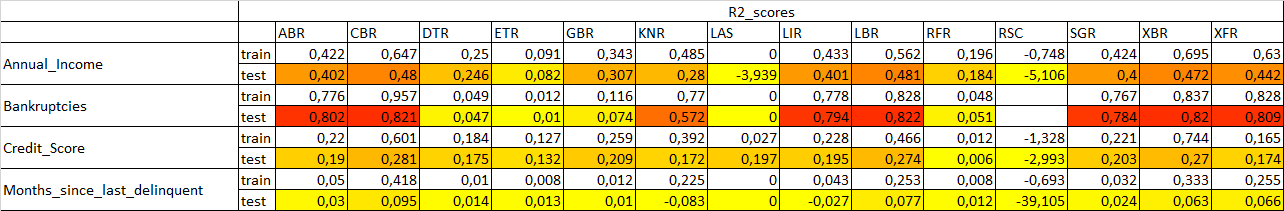